## Test for creating plots that show the time lag between planned activities and completed activities in only Boise National Forest.

### Author: Kaite Murenbeeld
### Init_Date: 17 Sept 2019, copied from Testing_Activity_TIming_PlannedVComp_BNF_TH
### Update: 

##### Within this notebook I will calculate time lags between planned and completed treatments. Also to plot in a effective way the difference between planned and completed activities. This will be done for all of Idaho, but will hopefully be a template to used for any other state or individual National Forests and even specifice NEPA projects.

In [1]:
# Import the appropriate libraries

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
import seaborn as sns

In [2]:
# Set the directories
raw_data_dir = '/Users/kathrynmurenbeeld/CODING/FOREST-TREATMENTS/DATA/FOREST-TREATMENTS/RAW/'
mod_data_dir = '/Users/kathrynmurenbeeld/CODING/FOREST-TREATMENTS/DATA/FOREST-TREATMENTS/MOD/'
output_data_dir = '/Users/kathrynmurenbeeld/Desktop/PROPOSAL/Figures/'

In [3]:
# Create dataframe from new csv
df = pd.read_csv(mod_data_dir + 'USA_TH_JULY2019.csv').reset_index()
df.head(1)

,index,ADMIN_FORE,ADMIN_REGI,ADMIN_FO_1,PROCLAIMED,ADMIN_DIST,ADMIN_DI_1,HOME_ORG,ACTIVITY_U,SUID,...,DATA_SOU_1,ACCURACY,CRC_VALUE,UK,EDW_INSERT,ETL_MODIFI,REV_DATE,GIS_ACRES,SHAPE_AREA,SHAPE_LEN
0,0,6,5,Lassen National Forest,506,Almanor Ranger District,51,50651,50651,050651T376000076000,...,NaN,0.0,NaN,NaN,2019-07-01,2019-07-01,2018-01-09,25.759,0.000011,0.026648


In [4]:
# Create new data frame for just Idaho National Forests
df2 = df.loc[df['STATE_ABBR']=='ID'].copy().reset_index()
#df2.head(5)

In [5]:
# Reduce the dataset by selecting the relevant columns
dfid = df2[['ADMIN_FO_1','ADMIN_DIST','NEPA_DOC_N','ACTIVITY_2','ACTIVITY_N','NBR_UNITS_','NBR_UNITS1','DATE_PLANN','DATE_AWARD','DATE_COMPL']].copy().reset_index()
#dfid.head(5)

In [6]:
# Group some of the activities together for later use. Use np.select(conditions, choices, default=). 
# Set your conditions to the ACTIVITY_2 codes, use isin() for when multiple codes will be grouped.

conditions = [
    (dfid['ACTIVITY_2']==4113), 
    (dfid['ACTIVITY_2']==4177),
    (dfid['ACTIVITY_2']==4111),
    (dfid['ACTIVITY_2']==4175),
    (dfid['ACTIVITY_2']==4152),
    (dfid['ACTIVITY_2']==4151),
    (dfid['ACTIVITY_2']==4220),
    (dfid['ACTIVITY_2'].isin([4231,4232,4210,4211])),
    (dfid['ACTIVITY_2'].isin([4102,4121,4131,4132])),
    (dfid['ACTIVITY_2'].isin([4192,4194,4162])),
    (dfid['ACTIVITY_2'].isin([4141,4142,4145,4146])),
    (dfid['ACTIVITY_2'].isin([4148,4196,4183,4193])),
    (dfid['ACTIVITY_2']==4143),
    (dfid['ACTIVITY_2']==4242)
]
choices = ['SCC','A2_SCC','PCC','A2_PCC','GT_CUT','ST_CUT','COMM_THIN','INT_CUT','REGEN_PREP','REGEN_PREP10','REGEN_REMOVE','REGEN_REMOVE10','OVERSTORE_CUT','HARV_NOSTOCK']

In [7]:
# Use np.select() to create a new column with the coded/grouped activities.

dfid['NEW_CODE'] = np.select(conditions, choices, default='none')
dfid.head(2) # check the data

,index,ADMIN_FO_1,ADMIN_DIST,NEPA_DOC_N,ACTIVITY_2,ACTIVITY_N,NBR_UNITS_,NBR_UNITS1,DATE_PLANN,DATE_AWARD,DATE_COMPL,NEW_CODE
0,0,Nez Perce - Clearwater National Forest,Red River Ranger District,DEFAULT FOR NOT REQUIRED,4131,Shelterwood Establishment Cut (with or without...,6.0,6.0,1987-07-01,1987-07-01,1987-07-01,REGEN_PREP
1,1,Idaho Panhandle National Forests,Sandpoint Ranger District,DEFAULT FOR NOT REQUIRED,4231,"Salvage Cut (intermediate treatment, not regen...",32.0,32.0,1968-06-01,1968-06-01,1968-06-01,INT_CUT


In [8]:
# Convert DATE_* columns to datetime. Add a new column for the serial dates
datearrP = dfid['DATE_PLANN'].values
datearr_dtP = pd.to_datetime(datearrP)
dfid['SerDatesPlan'] = datearr_dtP

datearrA = dfid['DATE_AWARD'].values
datearr_dtA = pd.to_datetime(datearrA)
dfid['SerDatesAward'] = datearr_dtA

datearrC = dfid['DATE_COMPL'].values
datearr_dtC = pd.to_datetime(datearrC)
dfid['SerDatesComp'] = datearr_dtC

dfid.head(1) # Check the data

,index,ADMIN_FO_1,ADMIN_DIST,NEPA_DOC_N,ACTIVITY_2,ACTIVITY_N,NBR_UNITS_,NBR_UNITS1,DATE_PLANN,DATE_AWARD,DATE_COMPL,NEW_CODE,SerDatesPlan,SerDatesAward,SerDatesComp
0,0,Nez Perce - Clearwater National Forest,Red River Ranger District,DEFAULT FOR NOT REQUIRED,4131,Shelterwood Establishment Cut (with or without...,6.0,6.0,1987-07-01,1987-07-01,1987-07-01,REGEN_PREP,1987-07-01,1987-07-01,1987-07-01


In [9]:
# Here I will sort out the data so that only items planned to be completed after 1956 and before 2019 
# are included.

#greater than the start date and smaller than the end date
mask = (dfid['SerDatesPlan'] > '1900-01-01') & (dfid['SerDatesPlan'] <= '2018-12-31')

# Create the subset for the range of dates when HFRA would be applied
dfid2 = dfid.loc[mask].copy()
# Check the date range
print(dfid2['SerDatesPlan'].min(), dfid2['SerDatesPlan'].max()) # Check the date range.

# Note: this method can be used for other policies of interest, such as NEPA, ESA, and NFMA.

1900-08-01 00:00:00 2018-12-31 00:00:00


In [10]:
# Create new data frames for Awarded and Completed by dropping the Nan values for those columns.
# Then, break out the Year, Month, Day for Plan, Accom, and Comp.

IDAward = dfid2.dropna(subset=['SerDatesAward']).copy()
IDComp = dfid2.dropna(subset=['SerDatesComp']).copy()

#Add the Y, M, D for the dataframes

dfid2['YP'] = dfid2['SerDatesPlan'].dt.year
dfid2['MP'] = dfid2['SerDatesPlan'].dt.month
dfid2['DP'] = dfid2['SerDatesPlan'].dt.day

IDAward['YP'] = dfid2['SerDatesPlan'].dt.year
IDAward['MP'] = dfid2['SerDatesPlan'].dt.month
IDAward['DP'] = dfid2['SerDatesPlan'].dt.day
IDAward['YA'] = IDAward['SerDatesAward'].dt.year
IDAward['MA'] = IDAward['SerDatesAward'].dt.month
IDAward['DA'] = IDAward['SerDatesAward'].dt.day

IDComp['YP'] = dfid2['SerDatesPlan'].dt.year
IDComp['MP'] = dfid2['SerDatesPlan'].dt.month
IDComp['DP'] = dfid2['SerDatesPlan'].dt.day
IDComp['YC'] = IDComp['SerDatesComp'].dt.year
IDComp['MC'] = IDComp['SerDatesComp'].dt.month
IDComp['DC'] = IDComp['SerDatesComp'].dt.day


dfid2['YA'] = IDAward['SerDatesAward'].dt.year
dfid2['MA'] = IDAward['SerDatesAward'].dt.month
dfid2['DA'] = IDAward['SerDatesAward'].dt.day
dfid2['YC'] = IDComp['SerDatesComp'].dt.year
dfid2['MC'] = IDComp['SerDatesComp'].dt.month
dfid2['DC'] = IDComp['SerDatesComp'].dt.day

#Check the Data
dfid2.head(1)


,index,ADMIN_FO_1,ADMIN_DIST,NEPA_DOC_N,ACTIVITY_2,ACTIVITY_N,NBR_UNITS_,NBR_UNITS1,DATE_PLANN,DATE_AWARD,...,SerDatesComp,YP,MP,DP,YA,MA,DA,YC,MC,DC
0,0,Nez Perce - Clearwater National Forest,Red River Ranger District,DEFAULT FOR NOT REQUIRED,4131,Shelterwood Establishment Cut (with or without...,6.0,6.0,1987-07-01,1987-07-01,...,1987-07-01,1987,7,1,1987.0,7.0,1.0,1987.0,7.0,1.0


In [11]:
# Check the Data
IDAward.head(1)

,index,ADMIN_FO_1,ADMIN_DIST,NEPA_DOC_N,ACTIVITY_2,ACTIVITY_N,NBR_UNITS_,NBR_UNITS1,DATE_PLANN,DATE_AWARD,...,NEW_CODE,SerDatesPlan,SerDatesAward,SerDatesComp,YP,MP,DP,YA,MA,DA
0,0,Nez Perce - Clearwater National Forest,Red River Ranger District,DEFAULT FOR NOT REQUIRED,4131,Shelterwood Establishment Cut (with or without...,6.0,6.0,1987-07-01,1987-07-01,...,REGEN_PREP,1987-07-01,1987-07-01,1987-07-01,1987,7,1,1987,7,1


In [12]:
# Check the Data
IDComp.head(1)

,index,ADMIN_FO_1,ADMIN_DIST,NEPA_DOC_N,ACTIVITY_2,ACTIVITY_N,NBR_UNITS_,NBR_UNITS1,DATE_PLANN,DATE_AWARD,...,NEW_CODE,SerDatesPlan,SerDatesAward,SerDatesComp,YP,MP,DP,YC,MC,DC
0,0,Nez Perce - Clearwater National Forest,Red River Ranger District,DEFAULT FOR NOT REQUIRED,4131,Shelterwood Establishment Cut (with or without...,6.0,6.0,1987-07-01,1987-07-01,...,REGEN_PREP,1987-07-01,1987-07-01,1987-07-01,1987,7,1,1987,7,1


In [13]:
# To create a time series can use the groupby function. 
# Useful stats tools to combine with the group by function include
# count(), sum(), and mean(). For now I will look at the total 
# area treated by year.

id_year = dfid2.groupby('YP').sum()
id_year = id_year.reset_index()
id_year.head(5)

,YP,index,ACTIVITY_2,NBR_UNITS_,NBR_UNITS1,MP,DP,YA,MA,DA,YC,MC,DC
0,1900,125300,21146,432.0,432.0,43,5,9550.0,43.0,5.0,9550.0,43.0,5.0
1,1901,27836,8440,45.0,45.0,16,2,3802.0,16.0,2.0,3802.0,16.0,2.0
2,1907,322738,55003,214.0,214.0,78,117,24791.0,78.0,117.0,24791.0,98.0,41.0
3,1908,279837,33848,189.0,189.0,54,8,15264.0,54.0,8.0,15264.0,54.0,8.0
4,1909,167801,25386,124.0,124.0,60,54,11454.0,60.0,54.0,11470.0,54.0,6.0


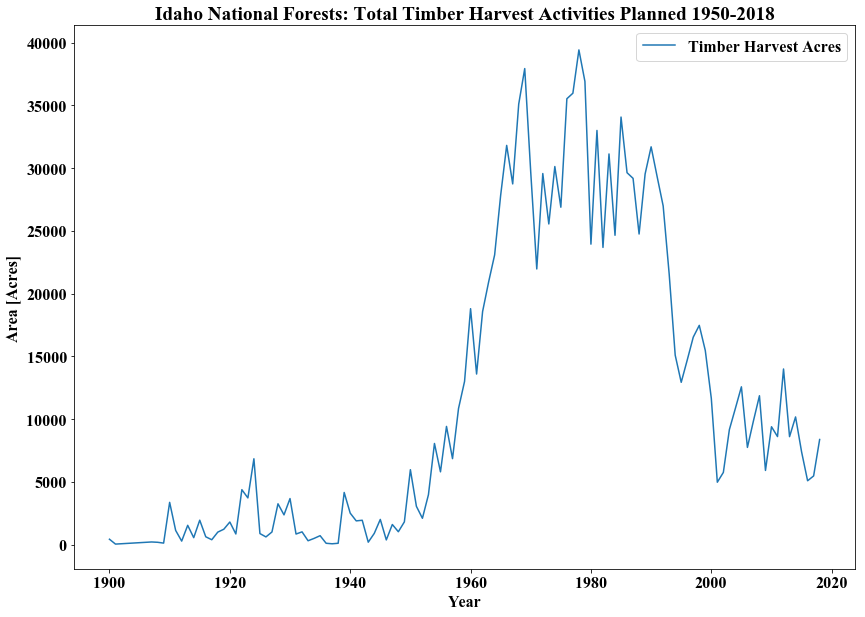

In [14]:
# Create a nice line plot

# First set the x (time) and y (area) variables 

ID_YP = id_year['YP'].values
ID_P_area = id_year['NBR_UNITS1'].values

fig1 = plt.figure(figsize=(14.0,10.0))

plt.rcParams.update({'font.size': 16})
plt.rcParams['font.family']='Times New Roman'

plt.plot(ID_YP,ID_P_area,label="Timber Harvest Acres")
plt.xlabel('Year')
plt.ylabel('Area [Acres]')
plt.title('Idaho National Forests: Total Timber Harvest Activities Planned 1950-2018')
#plt.savefig('fig_name.png', edgecolor='black', bbox_inches='tight', pad_inches=0.25)
plt.legend()
plt.show()

In [15]:
IDAward_year = dfid2.groupby('YA').sum()
IDAward_year = IDAward_year.reset_index()
IDAward_year.head(5)

,YA,index,ACTIVITY_2,NBR_UNITS_,NBR_UNITS1,YP,MP,DP,MA,DA,YC,MC,DC
0,1900.0,120821,16935,388.0,388.0,7600,35,4,35.0,4.0,7600.0,35.0,4.0
1,1901.0,27836,8440,45.0,45.0,3802,16,2,16.0,2.0,3802.0,16.0,2.0
2,1907.0,322738,55003,214.0,214.0,24791,78,117,78.0,117.0,24791.0,98.0,41.0
3,1908.0,279837,33848,189.0,189.0,15264,54,8,54.0,8.0,15264.0,54.0,8.0
4,1909.0,167801,25386,124.0,124.0,11454,60,54,60.0,54.0,11470.0,54.0,6.0


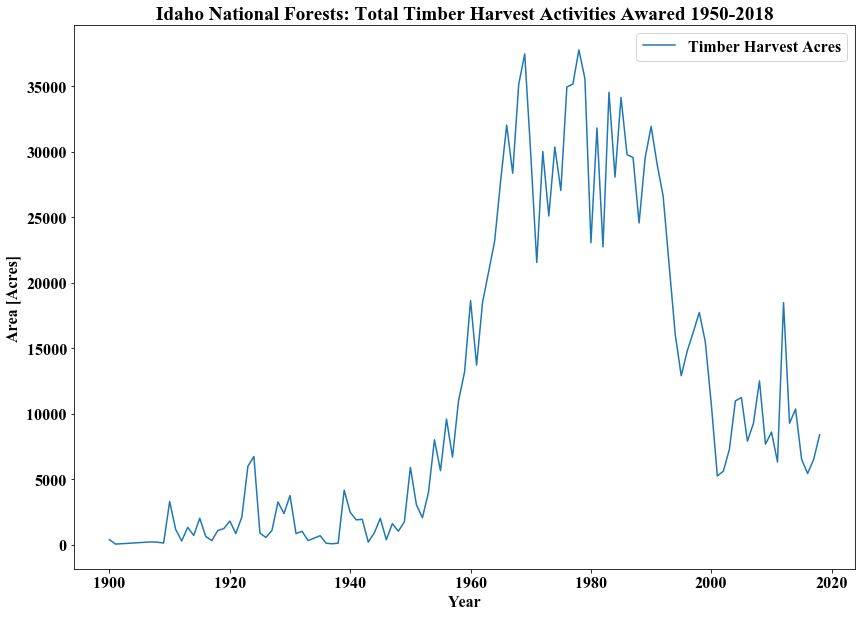

In [16]:
ID_YA = IDAward_year['YA'].values
ID_A_area = IDAward_year['NBR_UNITS1'].values

fig2 = plt.figure(figsize=(14.0,10.0))

plt.rcParams.update({'font.size': 16})
plt.rcParams['font.family']='Times New Roman'

plt.plot(ID_YA,ID_A_area,label="Timber Harvest Acres")
plt.xlabel('Year')
plt.ylabel('Area [Acres]')
plt.title('Idaho National Forests: Total Timber Harvest Activities Awared 1950-2018')
#plt.savefig('fig_name.png', edgecolor='black', bbox_inches='tight', pad_inches=0.25)
plt.legend()
plt.show()

In [17]:
IDComp_year = IDComp.groupby('YC').sum()
IDComp_year = IDComp_year.reset_index()
IDComp_year.head(5)

,YC,index,ACTIVITY_2,NBR_UNITS_,NBR_UNITS1,YP,MP,DP,MC,DC
0,1900,120821,16935,388.0,388.0,7600,35,4,35,4
1,1901,27836,8440,45.0,45.0,3802,16,2,16,2
2,1907,322738,55003,214.0,214.0,24791,78,117,98,41
3,1908,279837,33848,189.0,189.0,15264,54,8,54,8
4,1910,2140229,355004,2949.0,2949.0,160439,884,237,883,229


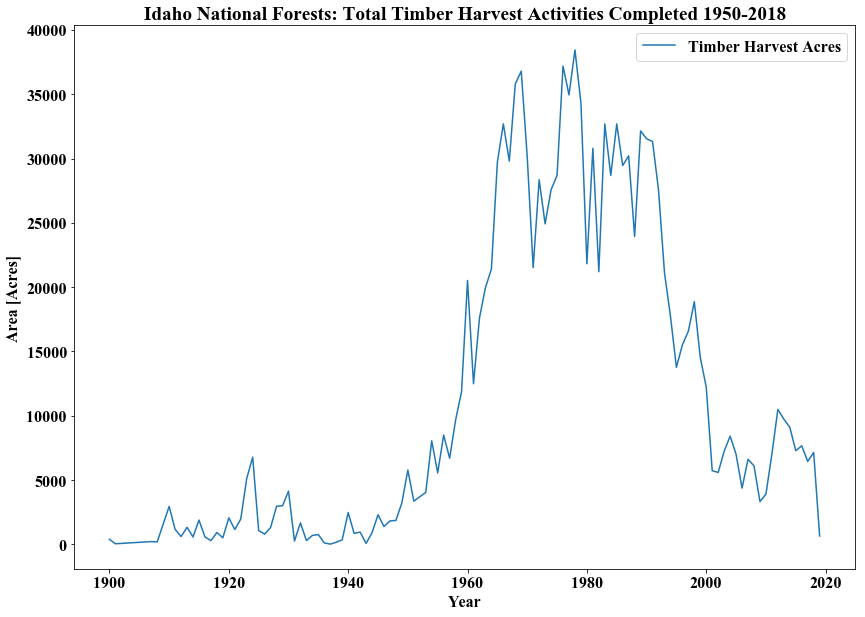

In [18]:
ID_YC = IDComp_year['YC'].values
ID_C_area = IDComp_year['NBR_UNITS1'].values

fig3 = plt.figure(figsize=(14.0,10.0))

plt.rcParams.update({'font.size': 16})
plt.rcParams['font.family']='Times New Roman'

plt.plot(ID_YC,ID_C_area,label="Timber Harvest Acres")
plt.xlabel('Year')
plt.ylabel('Area [Acres]')
plt.title('Idaho National Forests: Total Timber Harvest Activities Completed 1950-2018')
#plt.savefig('fig_name.png', edgecolor='black', bbox_inches='tight', pad_inches=0.25)
plt.legend()
plt.show()

In [19]:
# I want to make a stacked area plot for all timberharvest activities in Idaho: categories are:
# Clearcuts, Commercial Thins, Intermediate Cuts, and Other
# Need to make datasets by New Code Activities, then groupby year completed and then graph...Do I want
# Total Area or Number on Y-axis? Use IDComp to make subset datasets.
# I may have to export out csvs and remake. But this is what I want and with the policies set over it.
ID_SCC_C = IDComp.loc[IDComp['NEW_CODE']=='SCC'].copy().reset_index()
ID_CT_C = IDComp.loc[IDComp['NEW_CODE']=='COMM_THIN'].copy().reset_index()
ID_INT_C = IDComp.loc[IDComp['NEW_CODE']=='INT_CUT'].copy().reset_index()
#ID_OTHER_C = IDComp.loc[IDComp['NEW_CODE']!=['SCC'],['COMM_THIN'],['INT_CUT']].copy().reset_index()

ID_SCC_Cyear = ID_SCC_C.groupby('YC').count()
ID_SCC_Cyear = ID_SCC_Cyear.reset_index()

ID_CT_Cyear = ID_CT_C.groupby('YC').count()
ID_CT_Cyear = ID_CT_Cyear.reset_index()

ID_INT_Cyear = ID_INT_C.groupby('YC').count()
ID_INT_Cyear = ID_INT_Cyear.reset_index()

IDCompCount_year = IDComp.groupby('YC').count()
IDCompCount_year = IDCompCount_year.reset_index()

#ID_SCC_Cyear.to_csv("/Users/kathrynmurenbeeld/Desktop/ID_SCC_Cyear.csv")
ID_CT_Cyear.to_csv("/Users/kathrynmurenbeeld/Desktop/ID_CT_Cyear.csv")
ID_INT_Cyear.to_csv("/Users/kathrynmurenbeeld/Desktop/ID_INT_Cyear.csv")
IDCompCount_year.to_csv("/Users/kathrynmurenbeeld/Desktop/ID_ALL_Cyear.csv")

In [20]:
#ID_YCC = IDCompCount_year['YC'].values
#ID_C_count = IDCompCount_year['SerDatesComp'].values

#ID_SCC_Y = ID_SCC_Cyear['YC'].values
#ID_SCC_count = ID_SCC_Cyear['SerDatesComp'].values

#ID_CT_Y = ID_CT_Cyear['YC'].values
#ID_CT_count = ID_CT_Cyear['SerDatesComp'].values

#ID_INT_Y = ID_INT_Cyear['YC'].values
#ID_INT_count = ID_INT_Cyear['SerDatesComp'].values

#len(ID_YCC)
#ID_SCC_Cyear

In [21]:
ID_SCC_SP = pd.read_csv(mod_data_dir + 'ID_SCC_SP.csv').reset_index()
ID_CT_SP = pd.read_csv(mod_data_dir + 'ID_CT_SP.csv').reset_index()
ID_INT_SP = pd.read_csv(mod_data_dir + 'ID_INT_SP.csv').reset_index()
ID_ALL_SP = pd.read_csv(mod_data_dir + 'ID_ALL_SP.csv').reset_index()

ID_SCC_count = ID_SCC_SP['COUNT'].values
ID_CT_count = ID_CT_SP['COUNT'].values
ID_INT_count = ID_INT_SP['COUNT'].values
ID_ALL_count = ID_ALL_SP['COUNT'].values

ID_SCC_SP_Y = ID_SCC_SP['YC']
ID_ALL_SP_Y = ID_ALL_SP['YC']

ID_INT_count = ID_INT_count.astype(int)
ID_INT_count

array([  3,   0,   0,   0,   0,   0,   0,  13,   8,   0,  79,  39,  15,
        47,  25,  50,  21,  16,  40,  31,  87,  56,  72,  76,  86,  35,
        25,  30,  89,  91,  91,  11,  47,   9,  18,  19,   1,   0,   2,
        12,  54,  32,  27,   1,  27,  65,  18,  55,  32,  18, 122,  56,
        43, 101, 153,  59, 128,  97,  91,  91, 252, 125, 140, 119, 189,
       199, 307, 167, 242, 207, 264, 176, 171, 226, 260, 449, 531, 332,
       471, 404, 355, 462, 324, 448, 313, 320, 278, 325, 252, 292, 193,
       257, 304, 270, 349, 299, 514, 610, 742, 415, 388, 152,  97, 155,
        61,  81,  26,  56,  44,  26,  69,  23,  85,  75,  68,  43, 107,
        58,  35])

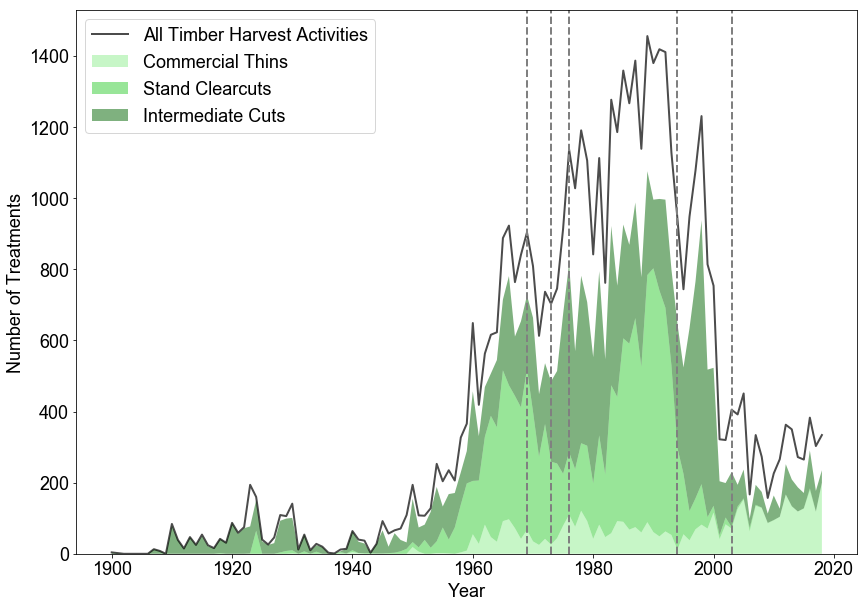

In [22]:
fig15 = plt.figure(figsize=(14.0,10.0))

plt.rcParams.update({'font.size': 18})
plt.rcParams['font.family']='Arial'

x = ID_ALL_SP_Y
y = [ [ID_SCC_count],[ID_CT_count],[ID_INT_count], [ID_ALL_count]]

plt.plot(ID_SCC_SP_Y,ID_ALL_count, linewidth=2, color='black', alpha=0.7, label="All Timber Harvest Activities")
#plt.plot(ID_SCC_Y, ID_SCC_count, label="Stand Clearcuts")
#plt.plot(ID_CT_Y, ID_CT_count, label="Commercial Thins")
#plt.plot(ID_INT_Y, ID_INT_count, label="Intermediate Cuts")
plt.stackplot(x, ID_CT_count, ID_SCC_count, ID_INT_count, 
              labels = ['Commercial Thins', 'Stand Clearcuts', 'Intermediate Cuts'],
             alpha=0.5, colors = ['lightgreen','limegreen','darkgreen'])
plt.axvline(x=1976, linewidth=2, color='grey', ls='--')
plt.axvline(x=1969, linewidth=2, color='grey', ls='--')
plt.axvline(x=1973, linewidth=2, color='grey', ls='--')
plt.axvline(x=1994, linewidth=2, color='grey', ls='--')
plt.axvline(x=2003, linewidth=2, color='grey', ls='--')
plt.xlabel('Year')
plt.ylabel('Number of Treatments')
#plt.title('Idaho National Forests: Total Timber Harvest Activities Completed 1900-2018')
plt.legend()
#plt.savefig('/Users/kathrynmurenbeeld/Desktop/PROPOSAL/Figures/test_PET_01.png', edgecolor='black', bbox_inches='tight', pad_inches=0.25)
plt.show()

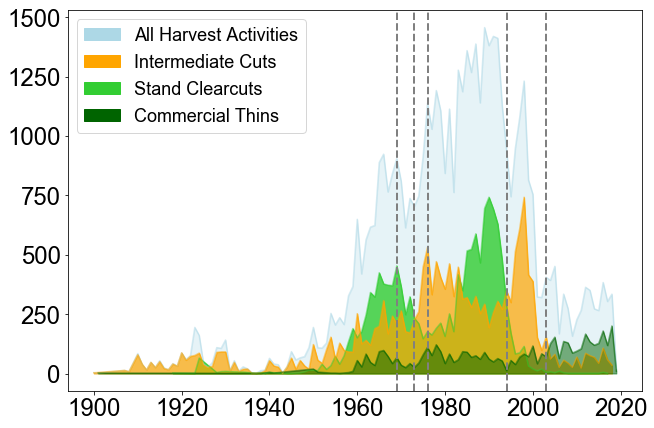

In [38]:
ID_YCC_t = IDCompCount_year['YC'].values
ID_C_count_t = IDCompCount_year['SerDatesComp'].values

ID_SCC_Y_t = ID_SCC_Cyear['YC'].values
ID_SCC_count_t = ID_SCC_Cyear['SerDatesComp'].values

ID_CT_Y_t = ID_CT_Cyear['YC'].values
ID_CT_count_t = ID_CT_Cyear['SerDatesComp'].values

ID_INT_Y_t = ID_INT_Cyear['YC'].values
ID_INT_count_t = ID_INT_Cyear['SerDatesComp'].values


fig16, ax = plt.subplots(figsize=(10.3,7))


plt.rcParams.update({'font.size': 24})
plt.rcParams['font.family']='Arial'

plt.plot(ID_YCC_t,ID_C_count_t,label="Timber Harvest Activities", color='lightblue', alpha = 0.5)
plt.fill_between(ID_YCC_t, ID_C_count_t, color='lightblue', alpha = 0.3)

plt.plot(ID_SCC_Y_t, ID_SCC_count_t, label="Stand Clearcuts", color='limegreen', alpha=0.5)
plt.fill_between(ID_SCC_Y_t, ID_SCC_count_t, color='limegreen', alpha=0.8)

plt.plot(ID_INT_Y_t, ID_INT_count_t, label="Intermediate Cuts", color='orange', alpha=0.5)
plt.fill_between(ID_INT_Y_t, ID_INT_count_t, color='orange', alpha=0.7)

plt.plot(ID_CT_Y_t, ID_CT_count_t, label="Commercial Thins", color='darkgreen', alpha=0.5)
plt.fill_between(ID_CT_Y_t, ID_CT_count_t, color='darkgreen', alpha=0.5)

plt.axvline(x=1976, linewidth=2, color='grey', ls='--')
plt.axvline(x=1969, linewidth=2, color='grey', ls='--')
plt.axvline(x=1973, linewidth=2, color='grey', ls='--')
plt.axvline(x=1994, linewidth=2, color='grey', ls='--')
plt.axvline(x=2003, linewidth=2, color='grey', ls='--', label='Enviro Law')
#plt.xlabel('Year', fontsize=22)
#plt.ylabel('Number of Treatments', fontsize=22)
#ax.tick_params(axis='y', colors='white')
#ax.tick_params(axis='x', colors='white')

lblue_patch = mpatches.Patch(color='lightblue', label='All Harvest Activities' )
orange_patch = mpatches.Patch(color='orange', label='Intermediate Cuts')
lime_patch = mpatches.Patch(color='limegreen', label='Stand Clearcuts')
dgreen_patch = mpatches.Patch(color='darkgreen', label='Commercial Thins')

#ax.spines['right'].set_color('lightgrey')
#ax.spines['top'].set_color('lightgrey')
#ax.spines['bottom'].set_color('lightgrey')
#ax.spines['left'].set_color('lightgrey')

plt.legend(handles=[lblue_patch, orange_patch, lime_patch, dgreen_patch], prop={'size': 18})
#legend = plt.legend(handles=[lblue_patch, orange_patch, lime_patch, dgreen_patch])
#plt.setp(legend.get_texts(), color='w')
plt.savefig('/Users/kathrynmurenbeeld/Desktop/SCHOOL/AGU/2019_FallMeeting/FIGURES/AGU_ENVIRONLAW_v01.png', edgecolor='black', bbox_inches='tight', pad_inches=0.1, 
           transparent=True)
plt.show()

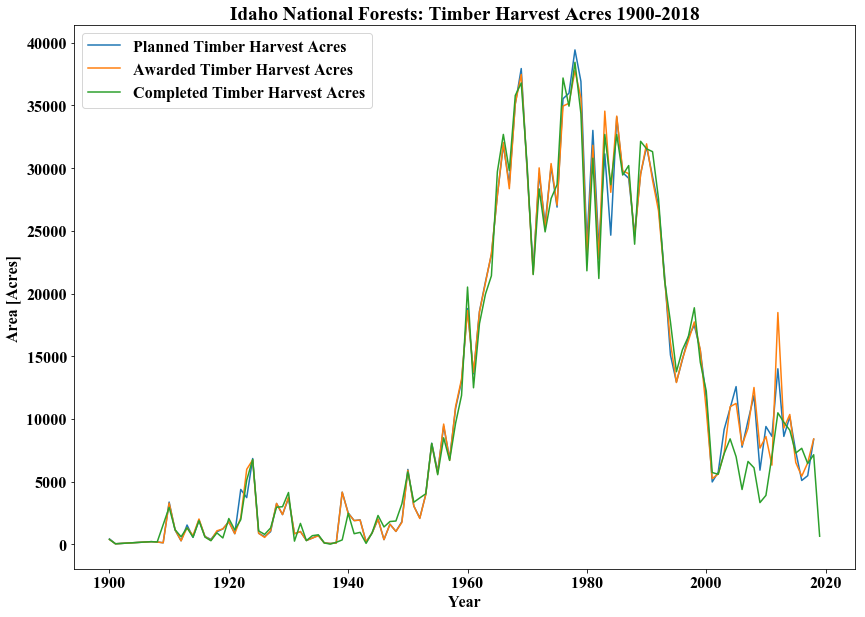

In [24]:
# Let's compare the three lines

fig4 = plt.figure(figsize=(14.0,10.0))

plt.rcParams.update({'font.size': 16})
plt.rcParams['font.family']='Times New Roman'

plt.plot(ID_YP,ID_P_area,label="Planned Timber Harvest Acres")
plt.plot(ID_YA,ID_A_area,label="Awarded Timber Harvest Acres")
plt.plot(ID_YC,ID_C_area,label="Completed Timber Harvest Acres")
plt.xlabel('Year')
plt.ylabel('Area [Acres]')
plt.title('Idaho National Forests: Timber Harvest Acres 1900-2018')
#plt.savefig(output_data_dir + 'fig_name.png', edgecolor='black', bbox_inches='tight', pad_inches=0.25)
plt.legend()
plt.show()

In [25]:
# Repeat the same process for the count of activities planned, awarded, or completed by year

IDPlan_year_count = dfid2.groupby('YP').count().reset_index()
IDAward_year_count = dfid2.groupby('YA').count().reset_index()
IDComp_year_count = dfid2.groupby('YC').count().reset_index()
IDComp_year_count.head(5)

,YC,index,ADMIN_FO_1,ADMIN_DIST,NEPA_DOC_N,ACTIVITY_2,ACTIVITY_N,NBR_UNITS_,NBR_UNITS1,DATE_PLANN,...,SerDatesAward,SerDatesComp,YP,MP,DP,YA,MA,DA,MC,DC
0,1900.0,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
1,1901.0,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
2,1907.0,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13
3,1908.0,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
4,1910.0,84,84,84,84,84,84,84,84,84,...,84,84,84,84,84,84,84,84,84,84


In [26]:
# Create the variables to plot

ID_YP_count = IDPlan_year_count['YP'].values
ID_P_count = IDPlan_year_count['NBR_UNITS1'].values

ID_YA_count = IDAward_year_count['YA'].values
ID_A_count = IDAward_year_count['NBR_UNITS1'].values

ID_YC_count = IDComp_year_count['YC'].values
ID_C_count = IDComp_year_count['NBR_UNITS1'].values

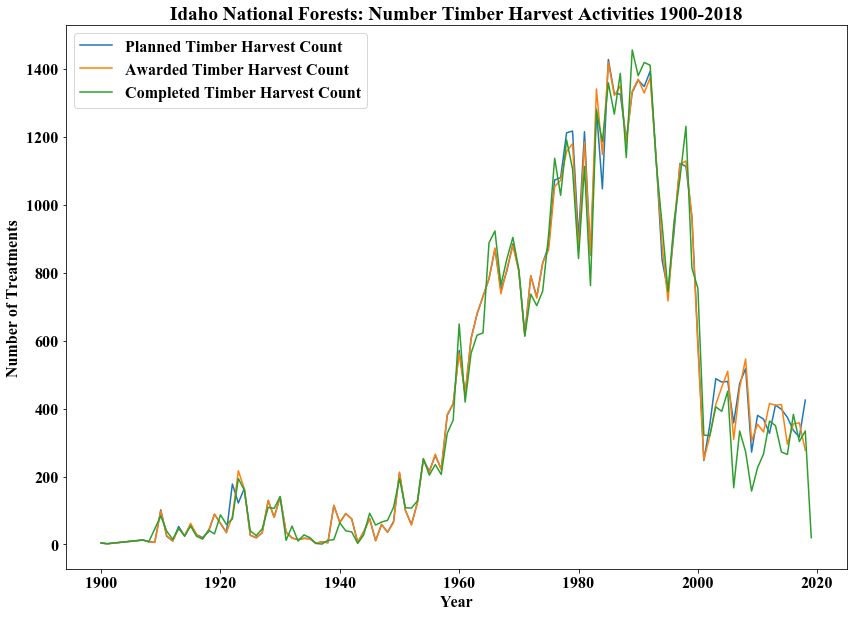

In [27]:
# Plot the lines 
fig5 = plt.figure(figsize=(14.0,10.0))

plt.rcParams.update({'font.size': 16})
plt.rcParams['font.family']='Times New Roman'

plt.plot(ID_YP_count,ID_P_count,label="Planned Timber Harvest Count")
plt.plot(ID_YA_count,ID_A_count,label="Awarded Timber Harvest Count")
plt.plot(ID_YC_count,ID_C_count,label="Completed Timber Harvest Count")
plt.xlabel('Year')
plt.ylabel('Number of Treatments')
plt.title('Idaho National Forests: Number Timber Harvest Activities 1900-2018')
#plt.savefig(output_data_dir + 'fig_name.png', edgecolor='black', bbox_inches='tight', pad_inches=0.25)
plt.legend()
plt.show()

Now I want to look at the time lags between planned and accomplished/completed activites. Can datetimes be added or subtracted?

In [28]:
# Yes you can add and subtract datetimes!!!

dfid2['Difference_Award'] = (dfid2['SerDatesAward'] - dfid2['SerDatesPlan']).dt.days
dfid2.head(6)

,index,ADMIN_FO_1,ADMIN_DIST,NEPA_DOC_N,ACTIVITY_2,ACTIVITY_N,NBR_UNITS_,NBR_UNITS1,DATE_PLANN,DATE_AWARD,...,YP,MP,DP,YA,MA,DA,YC,MC,DC,Difference_Award
0,0,Nez Perce - Clearwater National Forest,Red River Ranger District,DEFAULT FOR NOT REQUIRED,4131,Shelterwood Establishment Cut (with or without...,6.0,6.0,1987-07-01,1987-07-01,...,1987,7,1,1987.0,7.0,1.0,1987.0,7.0,1.0,0.0
1,1,Idaho Panhandle National Forests,Sandpoint Ranger District,DEFAULT FOR NOT REQUIRED,4231,"Salvage Cut (intermediate treatment, not regen...",32.0,32.0,1968-06-01,1968-06-01,...,1968,6,1,1968.0,6.0,1.0,1968.0,6.0,1.0,0.0
2,2,Idaho Panhandle National Forests,St. Maries Ranger District,DEFAULT FOR NOT REQUIRED,4113,Stand Clearcut (EA/RH/FH),6.0,6.0,1985-07-01,1985-07-01,...,1985,7,1,1985.0,7.0,1.0,1985.0,7.0,1.0,0.0
3,3,Idaho Panhandle National Forests,Wallace Ranger District,DEFAULT FOR NOT REQUIRED,4113,Stand Clearcut (EA/RH/FH),18.0,18.0,1969-06-01,1969-06-01,...,1969,6,1,1969.0,6.0,1.0,1969.0,6.0,1.0,0.0
4,4,Idaho Panhandle National Forests,Wallace Ranger District,DEFAULT FOR NOT REQUIRED,4231,"Salvage Cut (intermediate treatment, not regen...",29.0,29.0,1953-08-01,1953-08-01,...,1953,8,1,1953.0,8.0,1.0,1953.0,8.0,1.0,0.0
5,5,Salmon-Challis National Forest,Salmon-Cobalt Ranger District,(PALS)DECISION MEMO FOR DEEP CREEK RIDGE SALVA...,4220,Commercial Thin,8.0,8.0,2013-06-05,2014-09-19,...,2013,6,5,2014.0,9.0,19.0,2018.0,9.0,13.0,471.0


In [29]:
dfid2['Difference_Comp'] = (dfid2['SerDatesComp'] - dfid2['SerDatesPlan']).dt.days
dfid2.head(2)

,index,ADMIN_FO_1,ADMIN_DIST,NEPA_DOC_N,ACTIVITY_2,ACTIVITY_N,NBR_UNITS_,NBR_UNITS1,DATE_PLANN,DATE_AWARD,...,MP,DP,YA,MA,DA,YC,MC,DC,Difference_Award,Difference_Comp
0,0,Nez Perce - Clearwater National Forest,Red River Ranger District,DEFAULT FOR NOT REQUIRED,4131,Shelterwood Establishment Cut (with or without...,6.0,6.0,1987-07-01,1987-07-01,...,7,1,1987.0,7.0,1.0,1987.0,7.0,1.0,0.0,0.0
1,1,Idaho Panhandle National Forests,Sandpoint Ranger District,DEFAULT FOR NOT REQUIRED,4231,"Salvage Cut (intermediate treatment, not regen...",32.0,32.0,1968-06-01,1968-06-01,...,6,1,1968.0,6.0,1.0,1968.0,6.0,1.0,0.0,0.0


In [30]:
dfid2.groupby('NEW_CODE').mean()

,index,ACTIVITY_2,NBR_UNITS_,NBR_UNITS1,YP,MP,DP,YA,MA,DA,YC,MC,DC,Difference_Award,Difference_Comp
NEW_CODE,,,,,,,,,,,,,,,
A2_PCC,17840.000000,4175.000000,3.000000,3.000000,2017.000000,2.000000,1.000000,2017.000000,5.000000,31.000000,NaN,NaN,NaN,119.000000,NaN
A2_SCC,25549.191176,4177.000000,17.760294,17.760294,2010.367647,7.544118,15.352941,2010.367647,7.867647,17.426471,2011.379310,8.793103,14.465517,11.838235,875.086207
COMM_THIN,25786.171753,4220.000000,28.456476,27.371576,1995.551455,7.223031,9.474982,1995.093350,7.649434,10.911947,1993.598799,7.776512,7.570630,75.275849,459.819387
GT_CUT,25146.265700,4152.000000,23.261836,23.235427,1997.201288,7.371981,7.120773,1997.201613,7.548387,8.741935,1995.851718,7.264014,4.000000,19.425806,376.895118
HARV_NOSTOCK,25278.813754,4242.000000,12.018052,12.026648,1994.610315,7.515759,3.842407,1994.676218,7.707736,6.544413,1994.798851,7.660920,2.968391,32.578797,97.106322
INT_CUT,25906.134310,4226.524003,25.362760,25.268985,1978.209789,7.951936,4.026003,1978.166244,8.003424,4.229175,1977.962850,8.101639,2.633585,29.657477,129.367373
OVERSTORE_CUT,25256.360097,4143.000000,28.340633,28.240876,1979.133820,8.267640,10.664234,1979.070732,8.290244,10.519512,1979.090465,8.537897,10.075795,5.048780,53.388753
PCC,25852.155026,4111.000000,14.290630,14.246337,1984.427598,7.356048,4.456559,1984.694539,7.631399,4.745734,1982.875000,7.652174,3.427536,106.807167,153.429348
REGEN_PREP,25557.631500,4130.180915,28.136741,28.091955,1983.296760,7.813640,3.999455,1983.375682,7.879635,4.231325,1983.165721,8.038073,3.069085,44.531489,151.864184


In [31]:
# ACTIVITY 2-age patch clearcut has never been "completed" in Idaho National Forests 
# as of 2018, however, this activity was planned for the (PALS)BOTTOM CANYON PROJECT
# to be completed in 2017.

In [32]:
# To make the bar plots I want to I need to create a new data frame from
# the ID2018 groupby mean

ID_diff = dfid2.groupby('NEW_CODE').mean().reset_index()
ID_diff_sorted = ID_diff.sort_values(by = ['Difference_Comp']).reset_index()

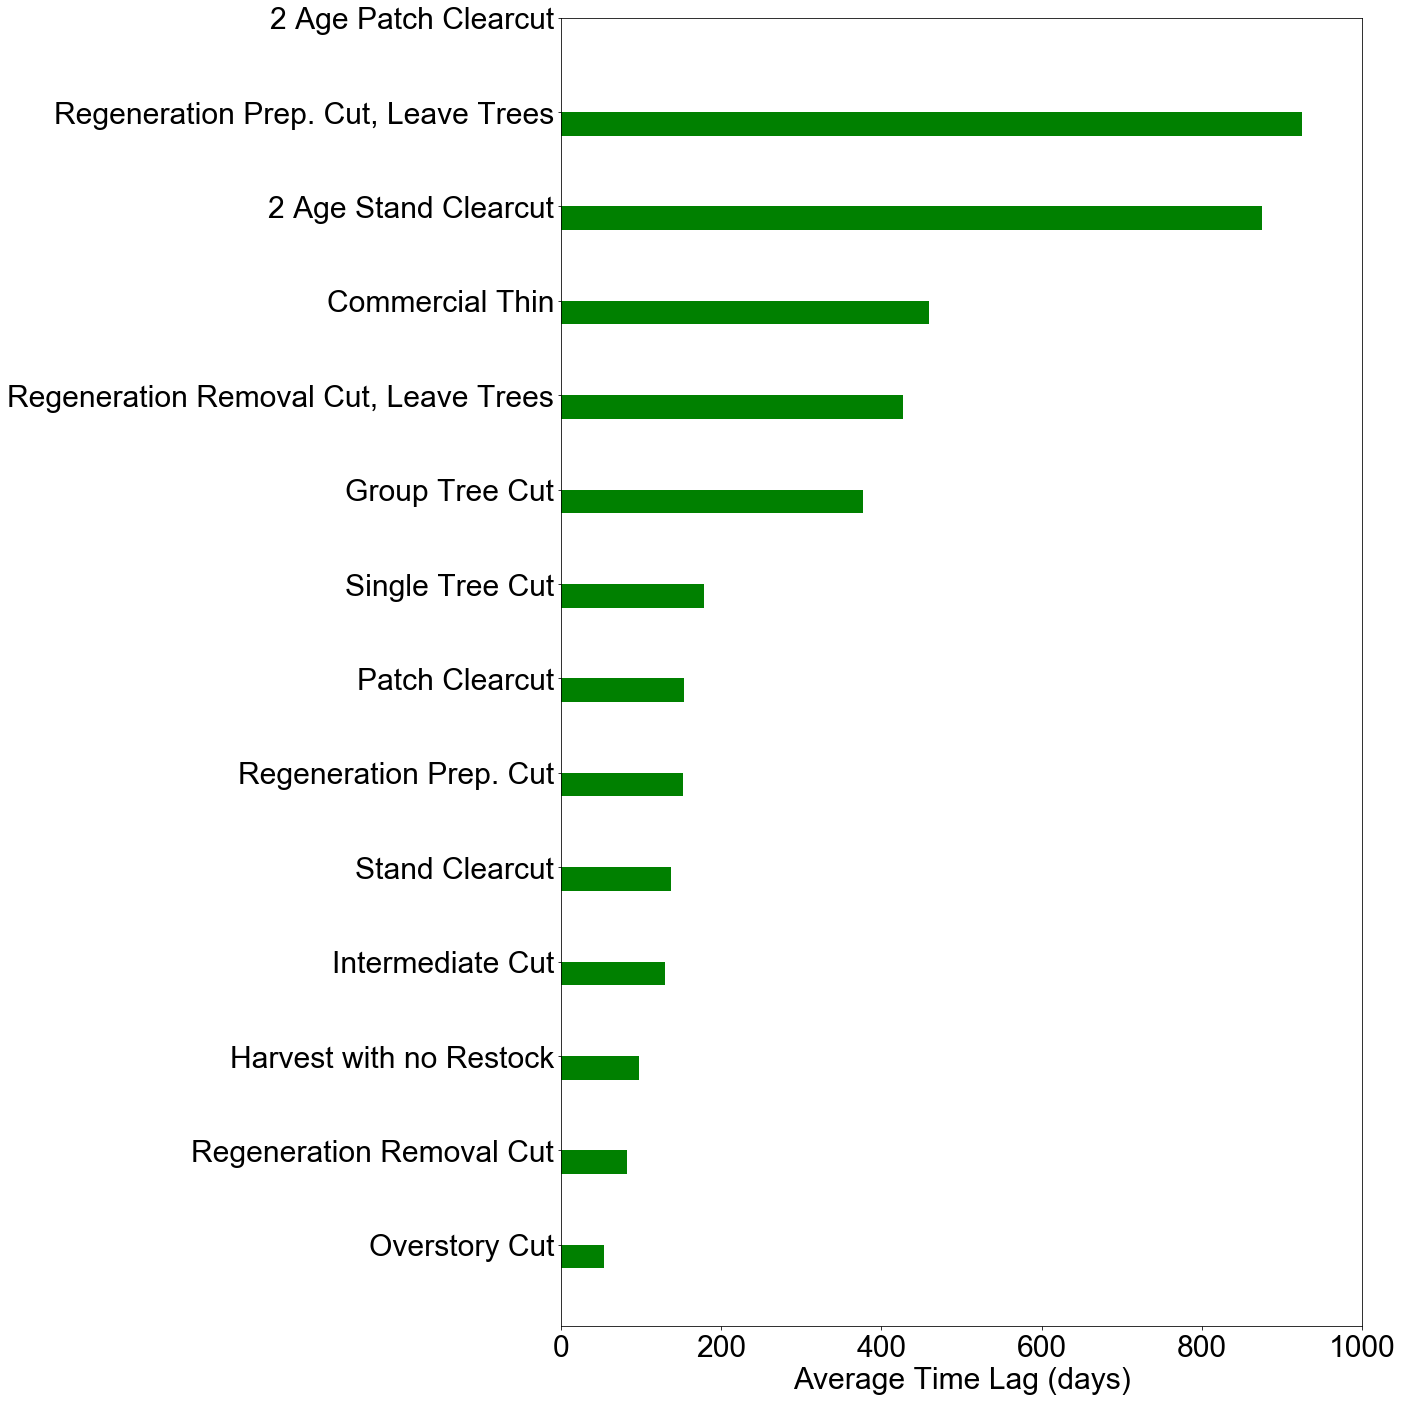

In [35]:
fig11, ax = plt.subplots(figsize=(20,20))

plt.rcParams.update({'font.size': 24})
plt.rcParams['font.family']='Arial'

activity = ID_diff_sorted['NEW_CODE']
diff_comp = ID_diff_sorted['Difference_Comp'].values
activity_full = ['2 Age Patch Clearcut', 'Regeneration Prep. Cut, Leave Trees', '2 Age Stand Clearcut',
                 'Commercial Thin','Regeneration Removal, Cut Leave Trees','Group Tree Cut','Single Tree Cut',
                'Patch Clearcut','Regeneration Prep. Cut','Stand Clearcut','Intermediate Cuts','Harvest with no Restock',
                'Regeneration Removal Cut','Overstory Cut']

activity_full2 = ['Overstory Cut', 'Regeneration Removal Cut', 'Harvest with no Restock',
                 'Intermediate Cut','Stand Clearcut','Regeneration Prep. Cut','Patch Clearcut',
                'Single Tree Cut','Group Tree Cut','Regeneration Removal Cut, Leave Trees','Commercial Thin',
                  '2 Age Stand Clearcut','Regeneration Prep. Cut, Leave Trees','2 Age Patch Clearcut']



ind = np.arange(len(activity))
width = 0.25

rects1 = ax.barh(ind - width/2, diff_comp, width, color = 'green')


#ax.set_ylabel('Treatment Type')
#ax.set_title('ID National Forests: Average Difference in Planned, Accomplished, and Completed Activity Times 1950-2018')
ax.set_yticklabels(activity_full2)
ax.set_yticks(ind)
plt.yticks(fontsize=30)
#ax.set_xticklabels(fontsize=22)
ax.tick_params(axis='x', pad=5)
ax.set_xlabel('Average Time Lag (days)', fontsize=30)
ax.set_xlim(0,1000)
plt.xticks(fontsize=30)
#plt.ylabel('Recoded Forest Management Activities', fontsize=24)
#ax.legend()

#def autolabel(rects, xpos='center'):
#    ha = {'center': 'center','right': 'left','left':'right'}
#    offset = {'center':0,'right':1,'left':-1}
    
 #   for rect in rects:
 #       height = rect.get_height()
 #       ax.annotate('{}'.format(height),
 #                   xy = (rect.get_x() + rect.get_width() / 2, height),
 #                   xytext=(offset[xpos]*3,3),
 #                   textcoords="offset points",
  #                  ha=ha[xpos], va = 'bottom')

fig11.tight_layout()
plt.savefig(output_data_dir + 'ID_PL-COMP_HBAR_v06.png', edgecolor='black', bbox_inches='tight', pad_inches=0.1)
plt.show()


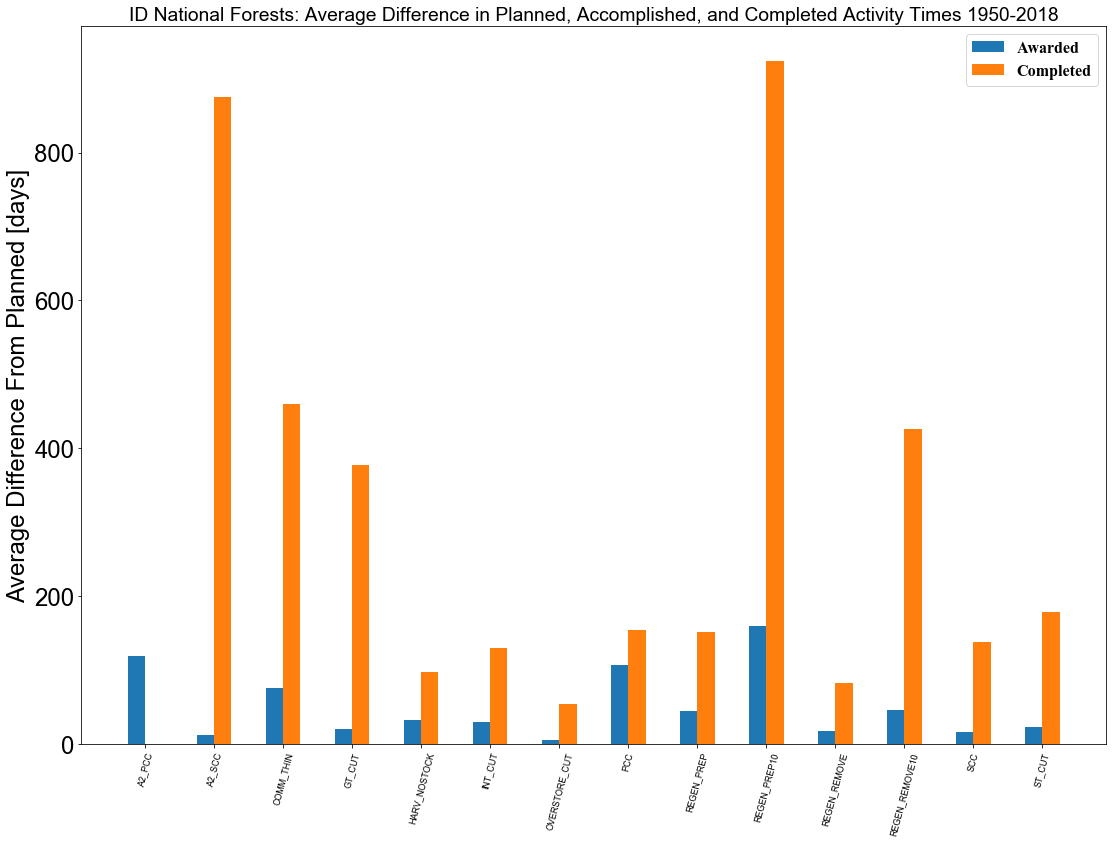

In [34]:
# So now I think I want to make a bar plot showing the average lag time 
# between planned/accomplished and planned/completed by activity type.

fig6, ax = plt.subplots(figsize=(16.0,12.0))

plt.rcParams.update({'font.size': 16})
plt.rcParams['font.family']='Times New Roman'


activity = ID_diff['NEW_CODE'].values
diff_award = ID_diff['Difference_Award'].values
diff_comp = ID_diff['Difference_Comp'].values

ind = np.arange(len(activity))
width = 0.25

rects1 = ax.bar(ind - width/2, diff_award, width, label='Awarded')
rects2 = ax.bar(ind + width/2, diff_comp, width, label='Completed')

ax.set_ylabel('Average Difference From Planned [days]')
ax.set_title('ID National Forests: Average Difference in Planned, Accomplished, and Completed Activity Times 1950-2018')
ax.set_xticks(ind)
ax.set_xticklabels(activity, rotation = 75, fontsize = 9)
ax.legend()

def autolabel(rects, xpos='center'):
    ha = {'center': 'center','right': 'left','left':'right'}
    offset = {'center':0,'right':1,'left':-1}
    
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy = (rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3,3),
                    textcoords="offset points",
                    ha=ha[xpos], va = 'bottom')

fig6.tight_layout()
#plt.savefig(output_data_dir + 'ID_PL_AC_COMP_TH.png', edgecolor='black', bbox_inches='tight', pad_inches=0.25)
plt.show()

In [35]:
# I can also look at the average month that activities are completed.

#ID2018Comp.head(2) # Check that it is the correct dataset

IDComp_avemonth = IDComp.groupby('NEW_CODE').mean().reset_index()
IDComp_avemonth.head(5)

,NEW_CODE,index,ACTIVITY_2,NBR_UNITS_,NBR_UNITS1,YP,MP,DP,YC,MC,DC
0,A2_SCC,26842.206897,4177.000000,17.775862,17.775862,2009.086207,7.534483,15.206897,2011.379310,8.793103,14.465517
1,COMM_THIN,25779.027548,4220.000000,28.404495,28.296334,1992.375311,7.308202,8.893123,1993.598799,7.776512,7.570630
2,GT_CUT,25039.453888,4152.000000,23.162206,23.142315,1994.820976,7.164557,6.578662,1995.851718,7.264014,4.000000
3,HARV_NOSTOCK,25310.936782,4242.000000,12.022989,12.031609,1994.543103,7.511494,3.850575,1994.798851,7.660920,2.968391
4,INT_CUT,25902.194365,4226.610732,25.228793,25.209883,1977.617373,7.957107,3.875867,1977.962850,8.101639,2.633585


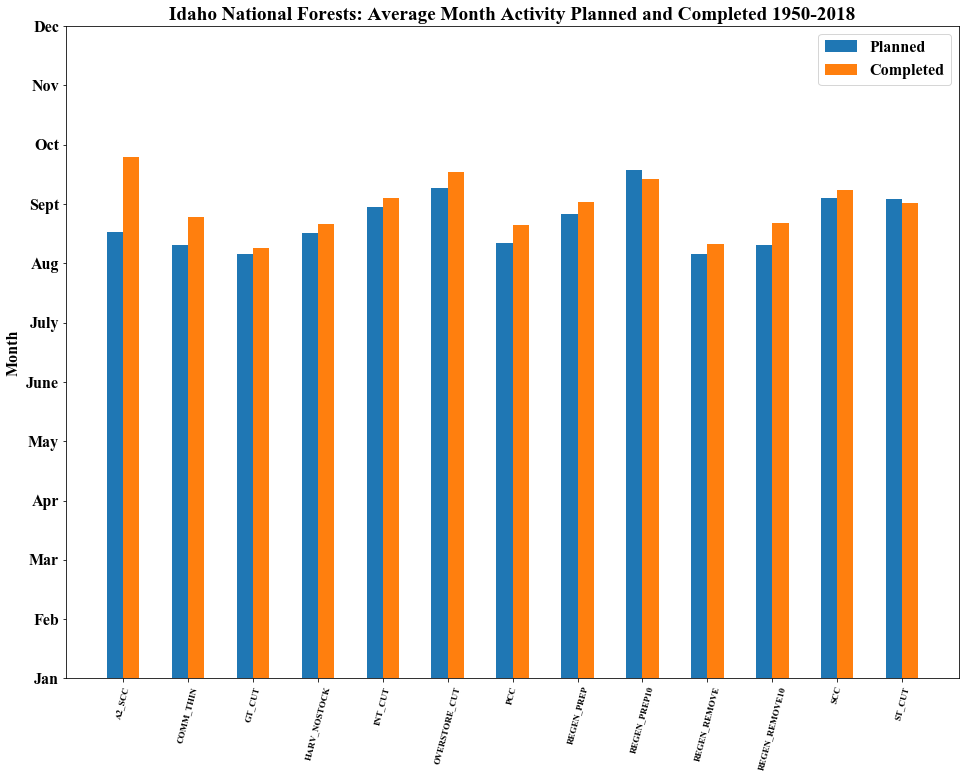

In [36]:
# Now I will look at average month planned vs average month completed
# by activity.

fig7, ax = plt.subplots(figsize=(16.0,12.0))

plt.rcParams.update({'font.size': 16})
plt.rcParams['font.family']='Times New Roman'


activity = IDComp_avemonth['NEW_CODE'].values
month_plan = IDComp_avemonth['MP'].values
month_comp = IDComp_avemonth['MC'].values

ind = np.arange(len(activity))
width = 0.25
yticks = np.arange(12)

rects1 = ax.bar(ind - width/2, month_plan, width, label='Planned')
rects2 = ax.bar(ind + width/2, month_comp, width, label='Completed')

ax.set_ylabel('Month')
ax.set_yticks(yticks)
ax.set_yticklabels(('Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec'))
ax.set_title('Idaho National Forests: Average Month Activity Planned and Completed 1950-2018')
ax.set_xticks(ind)
ax.set_xticklabels(activity, rotation = 75, fontsize = 9)
ax.legend()

def autolabel(rects, xpos='center'):
    ha = {'center': 'center','right': 'left','left':'right'}
    offset = {'center':0,'right':1,'left':-1}
    
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy = (rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3,3),
                    textcoords="offset points",
                    ha=ha[xpos], va = 'bottom')

fig6.tight_layout()
#plt.savefig(output_data_dir + 'ID_TH_MONTH_PL_COMP.png', edgecolor='black', bbox_inches='tight', pad_inches=0.25)
plt.show()

 I finally feel like I am getting the hang of this, and I feel like I can say so much about the data now!

In [77]:
IDComp['Difference_Comp'] = (IDComp['SerDatesComp'] - IDComp['SerDatesPlan']).dt.days
IDComp.head(2)

,index,ADMIN_FO_1,ADMIN_DIST,NEPA_DOC_N,ACTIVITY_2,ACTIVITY_N,NBR_UNITS_,NBR_UNITS1,DATE_PLANN,DATE_AWARD,...,SerDatesAward,SerDatesComp,YP,MP,DP,YC,MC,DC,Difference_Comp,Difference_Area
0,0,Nez Perce - Clearwater National Forest,Red River Ranger District,DEFAULT FOR NOT REQUIRED,4131,Shelterwood Establishment Cut (with or without...,6.0,6.0,1987-07-01,1987-07-01,...,1987-07-01,1987-07-01,1987,7,1,1987,7,1,0,0.0
1,1,Idaho Panhandle National Forests,Sandpoint Ranger District,DEFAULT FOR NOT REQUIRED,4231,"Salvage Cut (intermediate treatment, not regen...",32.0,32.0,1968-06-01,1968-06-01,...,1968-06-01,1968-06-01,1968,6,1,1968,6,1,0,0.0


In [78]:
IDComp['Difference_Area'] = (IDComp['NBR_UNITS1'] - IDComp['NBR_UNITS_'])
IDComp.head(2)

,index,ADMIN_FO_1,ADMIN_DIST,NEPA_DOC_N,ACTIVITY_2,ACTIVITY_N,NBR_UNITS_,NBR_UNITS1,DATE_PLANN,DATE_AWARD,...,SerDatesAward,SerDatesComp,YP,MP,DP,YC,MC,DC,Difference_Comp,Difference_Area
0,0,Nez Perce - Clearwater National Forest,Red River Ranger District,DEFAULT FOR NOT REQUIRED,4131,Shelterwood Establishment Cut (with or without...,6.0,6.0,1987-07-01,1987-07-01,...,1987-07-01,1987-07-01,1987,7,1,1987,7,1,0,0.0
1,1,Idaho Panhandle National Forests,Sandpoint Ranger District,DEFAULT FOR NOT REQUIRED,4231,"Salvage Cut (intermediate treatment, not regen...",32.0,32.0,1968-06-01,1968-06-01,...,1968-06-01,1968-06-01,1968,6,1,1968,6,1,0,0.0


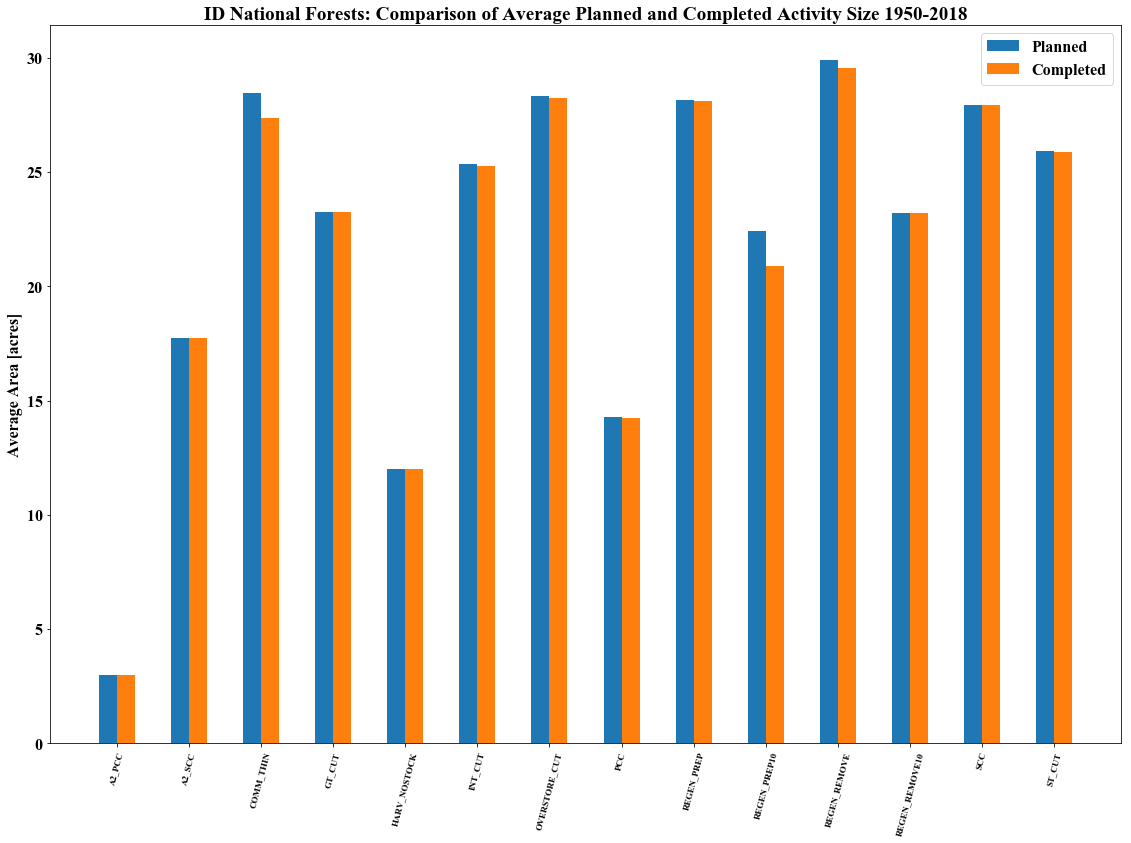

In [79]:
# So now I think I want to make a bar plot showing the average lag time 
# between planned/accomplished and planned/completed by activity type.

fig8, ax = plt.subplots(figsize=(16.0,12.0))

plt.rcParams.update({'font.size': 16})
plt.rcParams['font.family']='Times New Roman'


activity = ID_diff['NEW_CODE'].values
area_plan = ID_diff['NBR_UNITS_'].values
area_comp = ID_diff['NBR_UNITS1'].values

ind = np.arange(len(activity))
width = 0.25

rects1 = ax.bar(ind - width/2, area_plan, width, label='Planned')
rects2 = ax.bar(ind + width/2, area_comp, width, label='Completed')

ax.set_ylabel('Average Area [acres]')
ax.set_title('ID National Forests: Comparison of Average Planned and Completed Activity Size 1950-2018')
ax.set_xticks(ind)
ax.set_xticklabels(activity, rotation = 75, fontsize = 9)
ax.legend()

def autolabel(rects, xpos='center'):
    ha = {'center': 'center','right': 'left','left':'right'}
    offset = {'center':0,'right':1,'left':-1}
    
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy = (rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3,3),
                    textcoords="offset points",
                    ha=ha[xpos], va = 'bottom')

fig8.tight_layout()
#plt.savefig(output_data_dir + 'ID_PL_AC_COMP_TH.png', edgecolor='black', bbox_inches='tight', pad_inches=0.25)
plt.show()

This is a good stopping point for tonight (17 Spet 2019). I would like to create line plots with the counts of TH activities through time, and then by each of the new coded activites. I would also like to make line plots or the scatter plots with the average difference in time lag and size through time for all activities and each individual activity.

In [80]:
IDComp.groupby('NEW_CODE').count()

,index,ADMIN_FO_1,ADMIN_DIST,NEPA_DOC_N,ACTIVITY_2,ACTIVITY_N,NBR_UNITS_,NBR_UNITS1,DATE_PLANN,DATE_AWARD,...,SerDatesAward,SerDatesComp,YP,MP,DP,YC,MC,DC,Difference_Comp,Difference_Area
NEW_CODE,,,,,,,,,,,,,,,,,,,,,
A2_SCC,58,9,58,56,58,58,58,58,58,58,...,58,58,58,58,58,58,58,58,58,58
COMM_THIN,4828,4552,4819,4827,4828,4828,4828,4828,4828,4828,...,4828,4828,4828,4828,4828,4828,4828,4828,4828,4828
GT_CUT,553,492,553,552,553,553,553,553,553,553,...,553,553,553,553,553,553,553,553,553,553
HARV_NOSTOCK,348,312,348,348,348,348,348,348,348,348,...,348,348,348,348,348,348,348,348,348,348
INT_CUT,16716,13029,16696,16691,16716,16716,16716,16716,16716,16716,...,16716,16716,16716,16716,16716,16716,16716,16716,16716,16716
OVERSTORE_CUT,409,407,407,409,409,409,409,409,409,409,...,409,409,409,409,409,409,409,409,409,409
PCC,552,483,522,551,552,552,552,552,552,552,...,552,552,552,552,552,552,552,552,552,552
REGEN_PREP,7223,5525,7190,7204,7223,7223,7223,7223,7223,7223,...,7223,7223,7223,7223,7223,7223,7223,7223,7223,7223
REGEN_PREP10,160,116,156,160,160,160,160,160,160,160,...,160,160,160,160,160,160,160,160,160,160


In [81]:
# Can I look at specific projects and years?? 

# IDComp.groupby(['NEPA_DOC_N','NEW_CODE']).mean()

In [82]:
# Can look at specific projects and years? Yep! If I make a new dataframe will the years (or whatever the first groupby
# argument is) fill in? YES!!!

IDComp.groupby(['YP','NEW_CODE']).mean()
IDComp_year = IDComp.groupby(['YP','NEW_CODE']).mean().reset_index()
IDComp_year.head(5)

,YP,NEW_CODE,index,ACTIVITY_2,NBR_UNITS_,NBR_UNITS1,MP,DP,YC,MC,DC,Difference_Comp,Difference_Area
0,1900,HARV_NOSTOCK,274.000,4242.0,6.000000,6.000000,8.00,1.0,1900.0,8.000000,1.000000,0.000000,0.0
1,1900,INT_CUT,31256.500,4226.0,106.500000,106.500000,8.75,1.0,1912.5,8.750000,1.000000,4565.500000,0.0
2,1901,COMM_THIN,13918.000,4220.0,22.500000,22.500000,8.00,1.0,1901.0,8.000000,1.000000,0.000000,0.0
3,1907,INT_CUT,24826.000,4231.0,16.461538,16.461538,6.00,9.0,1907.0,7.538462,3.153846,41.230769,0.0
4,1908,INT_CUT,34979.625,4231.0,23.625000,23.625000,6.75,1.0,1908.0,6.750000,1.000000,0.000000,0.0


In [83]:
# I think it would be interesting to look at how specific activities have changed through time.

CT = IDComp_year.loc[IDComp_year['NEW_CODE'] == 'COMM_THIN'].copy().reset_index()
CT.head(5)

,level_0,YP,NEW_CODE,index,ACTIVITY_2,NBR_UNITS_,NBR_UNITS1,MP,DP,YC,MC,DC,Difference_Comp,Difference_Area
0,2,1901,COMM_THIN,13918.0,4220.0,22.5,22.5,8.0,1.0,1901.0,8.0,1.0,0.0,0.0
1,53,1930,COMM_THIN,44823.0,4220.0,24.0,24.0,6.0,1.0,1930.0,6.0,1.0,0.0,0.0
2,74,1938,COMM_THIN,26616.0,4220.0,36.0,36.0,10.0,1.0,1938.0,10.0,1.0,0.0,0.0
3,83,1940,COMM_THIN,19136.4,4220.0,41.8,41.8,11.0,1.0,1940.0,11.0,1.0,0.0,0.0
4,86,1941,COMM_THIN,14801.5,4220.0,50.0,50.0,6.0,1.0,1941.0,6.0,1.0,0.0,0.0


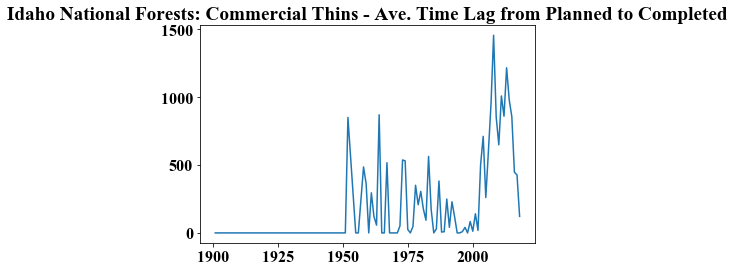

In [84]:
x_ct = CT['YP'].values
y_ct = CT['Difference_Comp']

plt.plot(x_ct,y_ct)
plt.title("Idaho National Forests: Commercial Thins - Ave. Time Lag from Planned to Completed")
#plt.savefig(output_data_dir + 'TEST_comthin_timelag.png', edgecolor='black', bbox_inches='tight', pad_inches=0.25)
#plt.scatter(x,y)
plt.show()

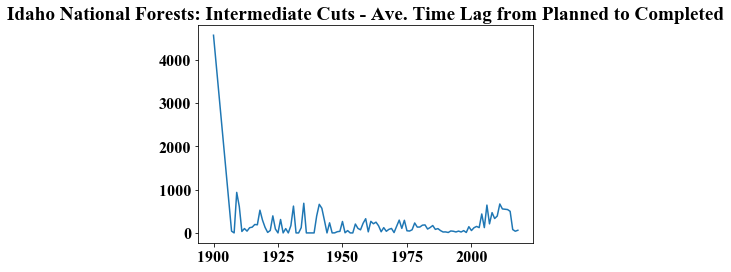

In [85]:
IC = IDComp_year.loc[IDComp_year['NEW_CODE'] == 'INT_CUT'].copy().reset_index()

x_ic = IC['YP'].values
y_ic = IC['Difference_Comp']

plt.plot(x_ic,y_ic)
plt.title("Idaho National Forests: Intermediate Cuts - Ave. Time Lag from Planned to Completed")
#plt.savefig(output_data_dir + 'TEST_comthin_timelag.png', edgecolor='black', bbox_inches='tight', pad_inches=0.25)
#plt.scatter(x,y)
plt.show()

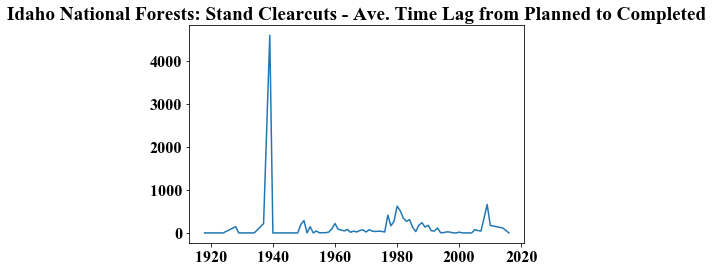

In [86]:
SCC = IDComp_year.loc[IDComp_year['NEW_CODE'] == 'SCC'].copy().reset_index()

x_scc = SCC['YP'].values
y_scc = SCC['Difference_Comp']

plt.plot(x_scc,y_scc)
plt.title("Idaho National Forests: Stand Clearcuts - Ave. Time Lag from Planned to Completed")
#plt.savefig(output_data_dir + 'TEST_comthin_timelag.png', edgecolor='black', bbox_inches='tight', pad_inches=0.25)
#plt.scatter(x,y)
plt.show()

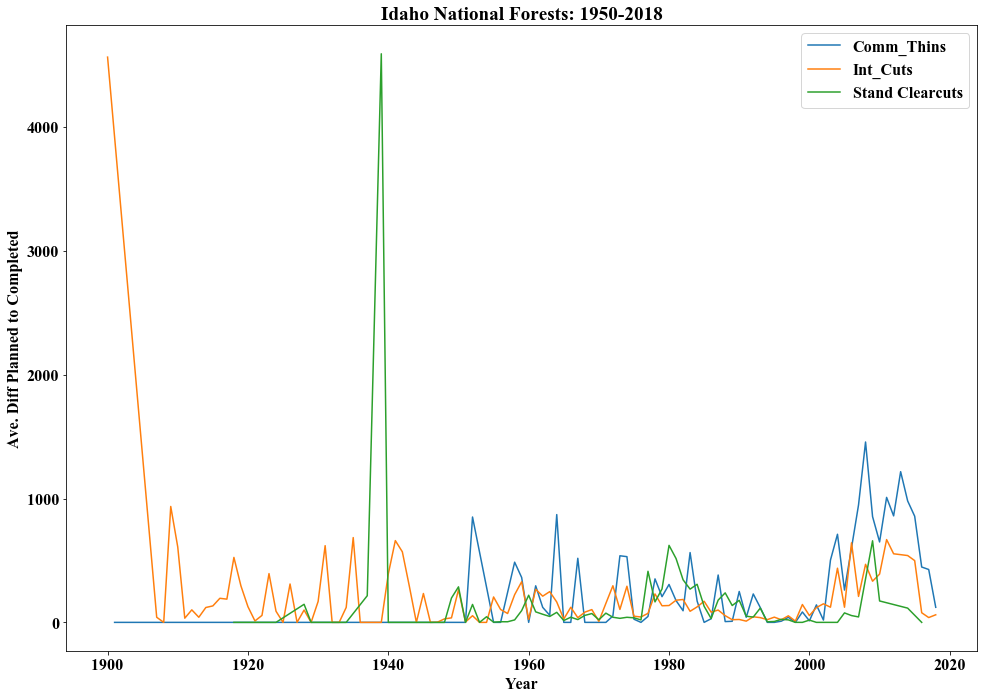

In [87]:
# Plot some of the common New Code activities
fig9 = plt.figure(figsize=(14.0,10.0))

plt.rcParams.update({'font.size': 16})
plt.rcParams['font.family']='Times New Roman'

plt.plot(x_ct,y_ct, label="Comm_Thins")
plt.plot(x_ic,y_ic, label="Int_Cuts")
plt.plot(x_scc,y_scc, label="Stand Clearcuts")
plt.xlabel('Year')
plt.ylabel('Ave. Diff Planned to Completed')
plt.title('Idaho National Forests: 1950-2018')
fig9.tight_layout()
plt.savefig(output_data_dir + 'timelags_time.png', edgecolor='black', bbox_inches='tight', pad_inches=0.25)
plt.legend()
plt.show()

16 July 2019: I think this is a good stopping point. I would like to make a figure like above but have the size of the scatter points change with average size. What I'm trying to show is how the lag time from plan comp date to actual comp date has changed through time (for specific activities, may be extra interesting to examine SALVAGE projects. I think that would be interesting to put into the context of what policies came into play or with changes in admin or Forest Chief...

In [88]:
# Work on the above scatter plot (size of dot = average # of activities and/or average size of activities) start with 
# Boise NF

Update: 25 July 2019 working on the figure above and incorporating the comments to create a scatter plot where the size of the dot is equal to the average # of activities or average size of activities.

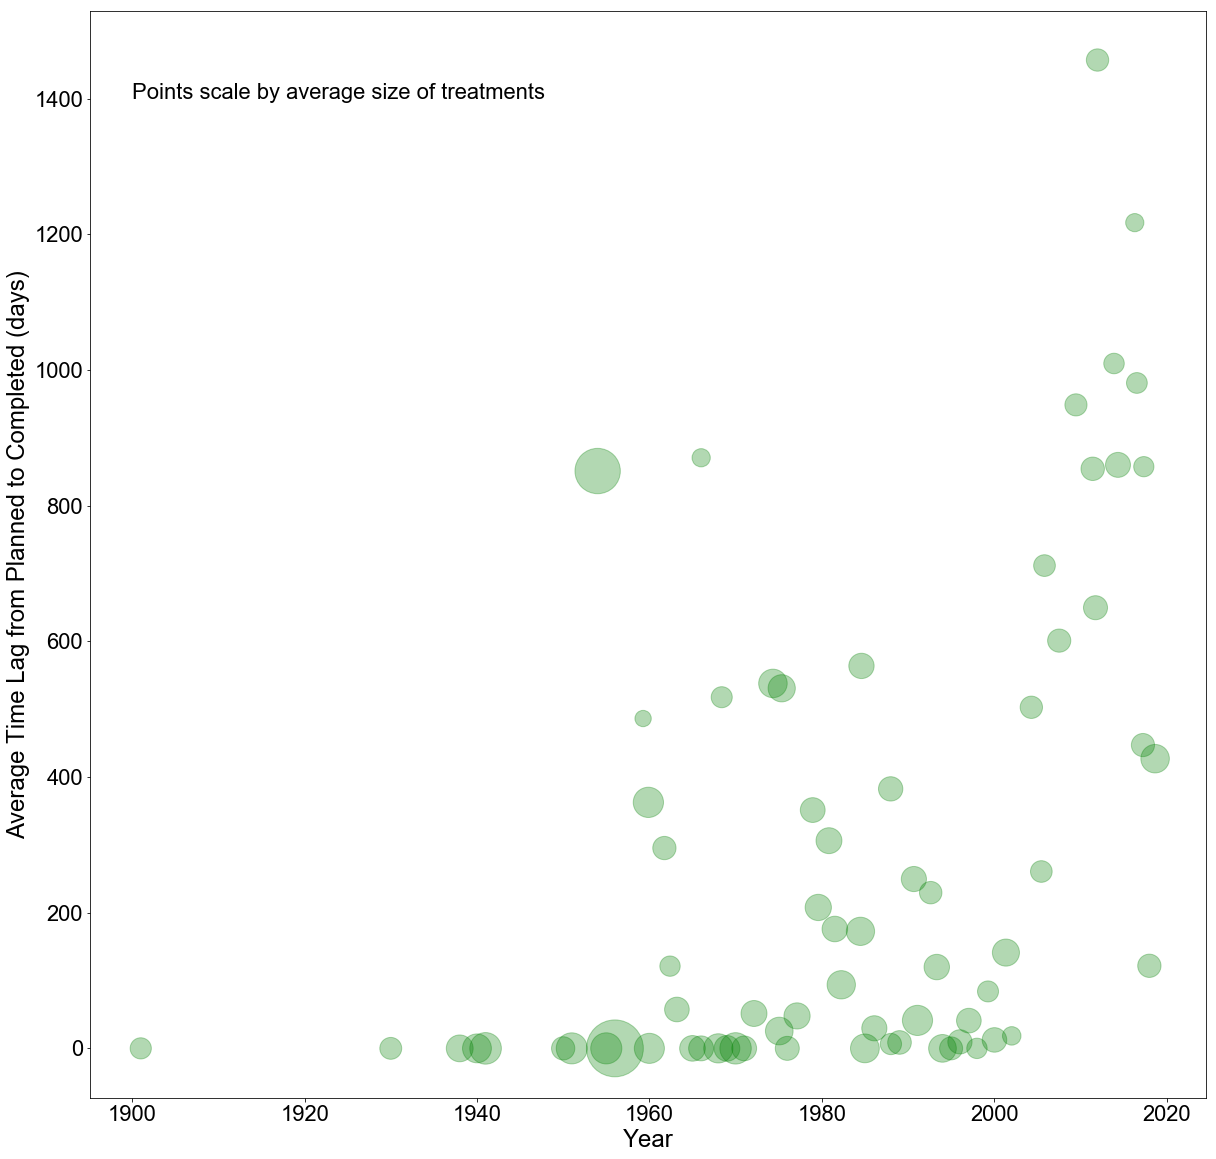

In [89]:
x1 = CT['YC'].values
y1 = CT['Difference_Comp']
scale = CT['NBR_UNITS1'].values

plt.rcParams.update({'font.size': 16})
plt.rcParams['font.family']='Arial'

fig = plt.figure(figsize = (20,20))
plt.scatter(x1,y1,s=20*scale, alpha = 0.3, c='green')
plt.text(1900,1400,'Points scale by average size of treatments', fontsize=22)
plt.yticks(fontsize=22)
plt.xticks(fontsize=22)
plt.ylabel('Average Time Lag from Planned to Completed (days)', fontsize = 24)
plt.xlabel('Year', fontsize = 24)
#plt.title("Idaho National Forest: Commercial Thins - Time Lag from Planned to Completed", fontsize = 28)
#plt.savefig(output_data_dir + 'comthin_timelag_scalesize_proposal.png', edgecolor='black', bbox_inches='tight', pad_inches=0.25)
#plt.scatter(x,y)
plt.show()

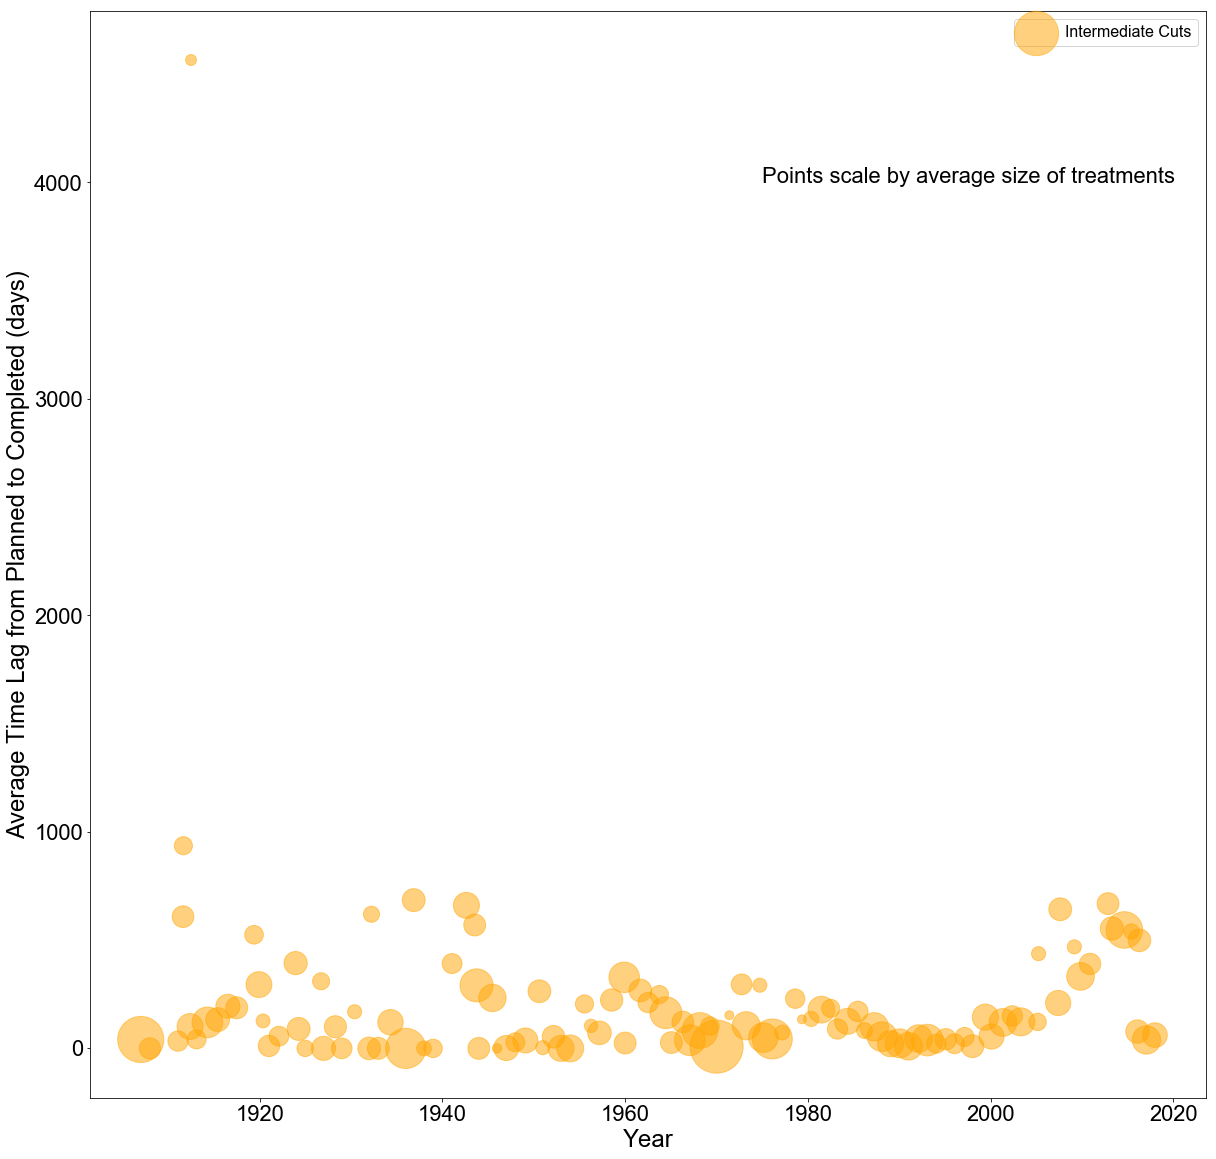

In [90]:
SCC = IDComp_year.loc[IDComp_year['NEW_CODE'] == 'SCC'].copy().reset_index()
INT = IDComp_year.loc[IDComp_year['NEW_CODE'] == 'INT_CUT'].copy().reset_index()

xall = IDComp_year['YC'].values
yall = IDComp_year['Difference_Comp']
scale_all = IDComp_year['NBR_UNITS1'].values

x_ct = CT['YC'].values
y_ct = CT['Difference_Comp']
scale_ct = CT['NBR_UNITS1'].values

x_scc = SCC['YC'].values
y_scc = SCC['Difference_Comp']
scale_scc = SCC['NBR_UNITS1'].values

x_int = INT['YC'].values
y_int = INT['Difference_Comp']
scale_int = INT['NBR_UNITS1'].values

plt.rcParams.update({'font.size': 16})
plt.rcParams['font.family']='Arial'

fig = plt.figure(figsize = (20,20))
#plt.scatter(xall,yall,s=20*scale_all, alpha = 0.3, c='darkgreen', label="All Treatment Types")
#plt.scatter(x_ct,y_ct,s=20*scale_all, alpha = 0.3, c='purple', label="Commercial Thins")
#plt.scatter(x_scc,y_scc,s=20*scale_all, alpha = 0.3, c='red', label="Stand Clearcuts")
plt.scatter(x_int, y_int,s=20*scale_all, alpha=0.5, c='orange', label='Intermediate Cuts')
plt.text(1975,4000,'Points scale by average size of treatments', fontsize=22)
plt.yticks(fontsize=22)
plt.xticks(fontsize=22)
plt.ylabel('Average Time Lag from Planned to Completed (days)', fontsize = 24)
plt.xlabel('Year', fontsize = 24)
plt.legend(loc='upper right')
#plt.title("Idaho National Forest: Commercial Thins - Time Lag from Planned to Completed", fontsize = 28)
#plt.savefig(output_data_dir + 'IDall_TH-ic_timelag_scalesize_proposal_v01.png', edgecolor='black', bbox_inches='tight', pad_inches=0.25)
#plt.scatter(x,y)
plt.show()

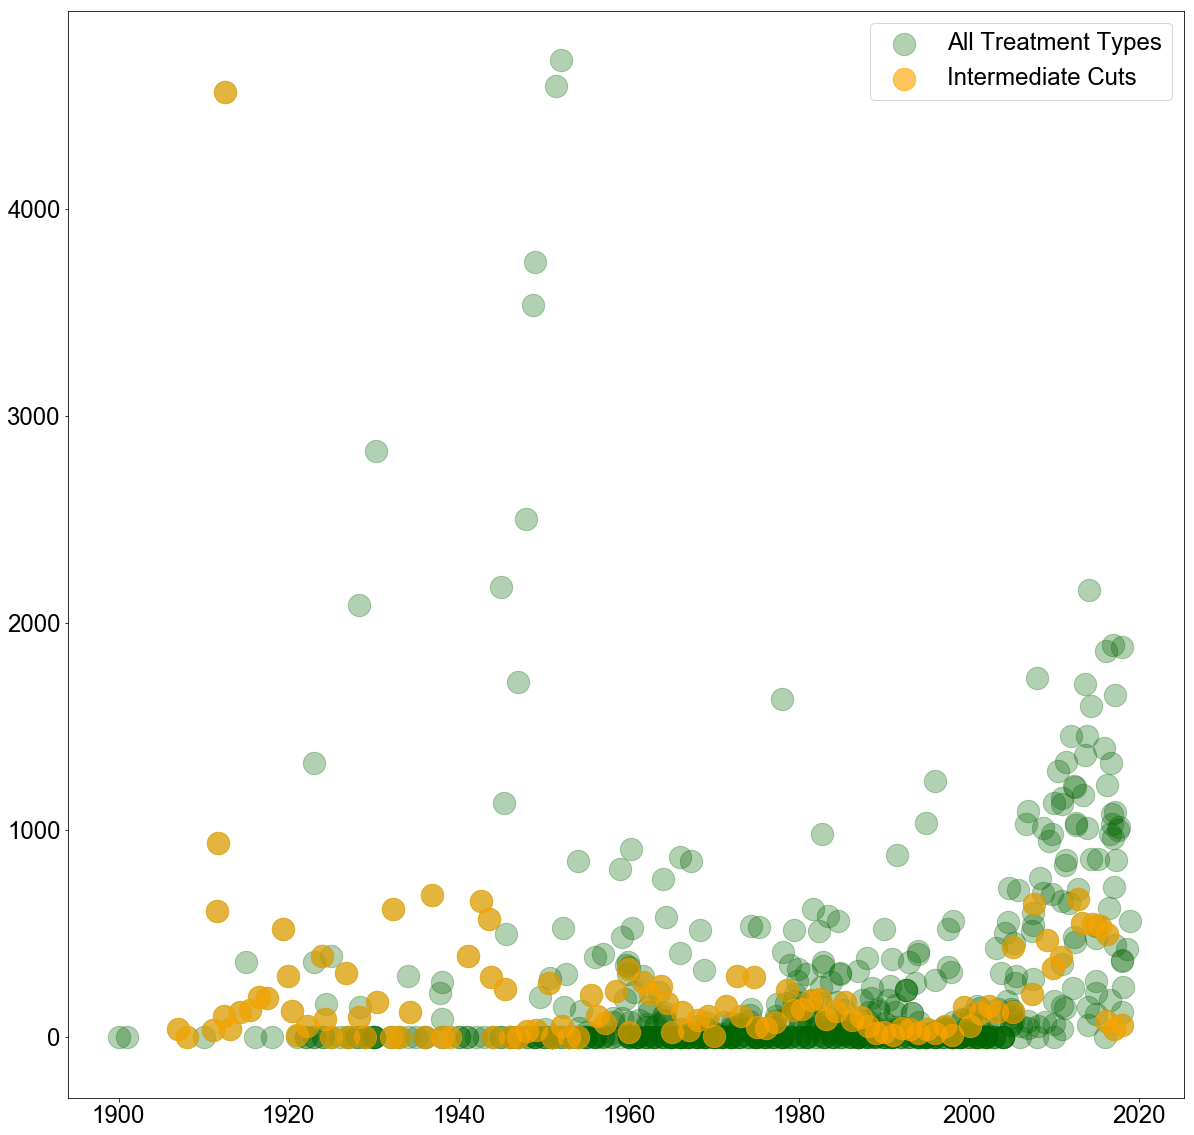

In [132]:
fig,ax = plt.subplots(figsize = (20,20))

plt.rcParams.update({'font.size': 24})
plt.rcParams['font.family']='Arial'

plt.scatter(xall,yall, s=500, alpha = 0.3, c='darkgreen', label="All Treatment Types")
#plt.scatter(x_ct,y_ct, s=500, alpha = 0.6, c='purple', label="Commercial Thins")
#plt.scatter(x_scc,y_scc, s=500, alpha = 0.6, c='red', label="Stand Clearcuts")
plt.scatter(x_int, y_int, s=500, alpha=0.65, c='orange', label='Intermediate Cuts')
#plt.text(1975,4000,'Points scale by average size of treatments', fontsize=22)
plt.yticks(fontsize=24)
plt.xticks(fontsize=24)
#plt.ylabel('Average Time Lag (days)', fontsize = 24, rotation = 0)
#ax.yaxis.set_label_coords(-0.15, 0.5)
#plt.xlabel('Year', fontsize = 24)
plt.legend(loc='upper right')
#plt.title("Idaho National Forest: Commercial Thins - Time Lag from Planned to Completed", fontsize = 28)
plt.savefig(output_data_dir + 'IDall_TH-ic_timelag_all-int_proposal_v01.png', edgecolor='black', bbox_inches='tight', pad_inches=0.25)
#plt.scatter(x,y)
plt.show()

In [66]:
IDComp_year.head(10)

,YP,NEW_CODE,index,ACTIVITY_2,NBR_UNITS_,NBR_UNITS1,MP,DP,YC,MC,DC,Difference_Comp,Difference_Area
0,1900,HARV_NOSTOCK,274.000000,4242.0,6.000000,6.000000,8.000000,1.000000,1900.000000,8.000000,1.000000,0.000000,0.0
1,1900,INT_CUT,31256.500000,4226.0,106.500000,106.500000,8.750000,1.000000,1912.500000,8.750000,1.000000,4565.500000,0.0
2,1901,COMM_THIN,13918.000000,4220.0,22.500000,22.500000,8.000000,1.000000,1901.000000,8.000000,1.000000,0.000000,0.0
3,1907,INT_CUT,24826.000000,4231.0,16.461538,16.461538,6.000000,9.000000,1907.000000,7.538462,3.153846,41.230769,0.0
4,1908,INT_CUT,34979.625000,4231.0,23.625000,23.625000,6.750000,1.000000,1908.000000,6.750000,1.000000,0.000000,0.0
5,1909,INT_CUT,27966.833333,4231.0,20.666667,20.666667,10.000000,9.000000,1911.666667,9.000000,1.000000,936.166667,0.0
6,1910,INT_CUT,25430.587629,4231.0,33.824742,33.824742,9.773196,2.443299,1911.628866,10.113402,5.494845,608.412371,0.0
7,1910,ST_CUT,27987.800000,4151.0,18.000000,18.000000,9.000000,30.000000,1910.000000,9.000000,30.000000,0.000000,0.0
8,1911,INT_CUT,25767.916667,4231.0,47.250000,47.250000,8.583333,1.833333,1911.083333,8.625000,3.833333,33.791667,0.0
9,1912,INT_CUT,34746.700000,4231.0,28.400000,28.400000,8.900000,6.400000,1912.400000,7.600000,1.000000,101.100000,0.0


In [35]:
idk_count = BOI2018Comp.groupby(['YP','ACTIVITY_2']).count().reset_index()
idk_count

,YP,ACTIVITY_2,index,ADMIN_FORE,ADMIN_FO_1,ADMIN_DIST,ACTIVITY_N,NEPA_PROJE,NEPA_DOC_N,IMPLEMENTA,NBR_UNITS1,SerDatesPlan,SerDatesAccom,SerDatesComp,YC,MC,DC,MP,DP,Difference_Comp
0,1967,4113,21,21,21,21,21,21,21,0,21,21,21,21,21,21,21,21,21,21
1,1985,4151,3,3,3,3,3,3,3,0,3,3,3,3,3,3,3,3,3,3
2,1988,4151,3,3,3,3,3,3,3,0,3,3,3,3,3,3,3,3,3,3
3,1989,4113,6,6,6,6,6,6,6,0,6,6,6,6,6,6,6,6,6,6
4,1989,4145,6,6,6,6,6,6,6,0,6,6,6,6,6,6,6,6,6,6
5,1990,4113,30,30,30,30,30,30,30,0,30,30,30,30,30,30,30,30,30,30
6,1990,4131,9,9,9,9,9,9,9,0,9,9,9,9,9,9,9,9,9,9
7,1990,4145,6,6,6,6,6,6,6,0,6,6,6,6,6,6,6,6,6,6
8,1992,4231,18,18,18,18,18,18,18,0,18,18,18,18,18,18,18,18,18,18
9,1996,4231,21,21,21,21,21,21,21,0,21,21,21,21,21,21,21,21,21,21


In [36]:
testCT_count = idk_count.loc[idk_count['ACTIVITY_2'] == 4220].copy().reset_index()
testCT_count

,level_0,YP,ACTIVITY_2,index,ADMIN_FORE,ADMIN_FO_1,ADMIN_DIST,ACTIVITY_N,NEPA_PROJE,NEPA_DOC_N,...,NBR_UNITS1,SerDatesPlan,SerDatesAccom,SerDatesComp,YC,MC,DC,MP,DP,Difference_Comp
0,12,1997,4220,18,18,18,18,18,18,18,...,18,18,18,18,18,18,18,18,18,18
1,20,2000,4220,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24
2,24,2001,4220,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
3,30,2002,4220,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
4,31,2003,4220,33,33,33,6,33,33,33,...,33,33,33,33,33,33,33,33,33,33
5,36,2004,4220,105,105,105,105,105,105,105,...,105,105,105,105,105,105,105,105,105,105
6,43,2005,4220,72,72,72,72,72,72,72,...,72,72,72,72,72,72,72,72,72,72
7,45,2006,4220,84,84,84,84,84,84,84,...,84,84,84,84,84,84,84,84,84,84
8,50,2007,4220,120,120,120,120,120,120,120,...,120,120,120,120,120,120,120,120,120,120
9,57,2008,4220,63,63,63,63,63,63,63,...,63,63,63,63,63,63,63,63,63,63


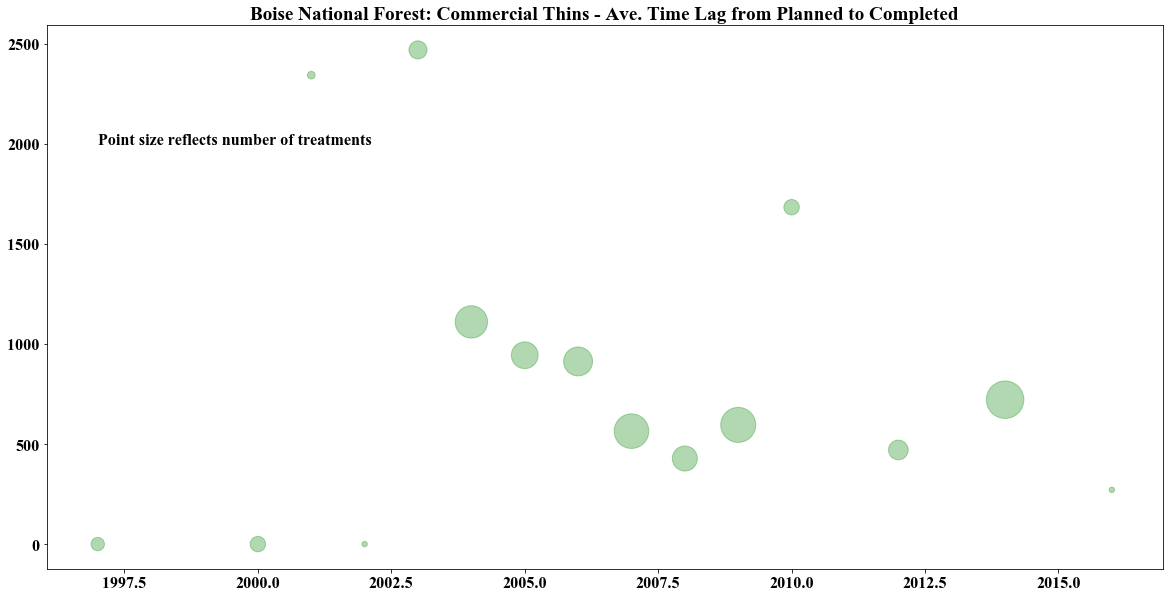

In [37]:
x2 = testCT_count['YP'].values
scale2 = testCT_count['NBR_UNITS1'].values

fig = plt.figure(figsize = (20,10))
plt.scatter(x2,y1,s=10*scale2, alpha = 0.3, c='green')
plt.text(1997,2000,'Point size reflects number of treatments')
plt.title("Boise National Forest: Commercial Thins - Ave. Time Lag from Planned to Completed")
#plt.savefig(output_data_dir + 'comthin_timelag_scalenum.png', edgecolor='black', bbox_inches='tight', pad_inches=0.25)
#plt.scatter(x,y)
plt.show()